# Analysis of NMF spatial and temporal components (peaks) and acc heart muscle traces
This is the actual script used for the report with the actual figures

In [1]:
from my_utils import utils
import os
import pickle
import importlib
from matplotlib import pyplot as plt
from scipy.signal import find_peaks, peak_widths
import numpy as np
import cv2

In [ ]:
# Define the pupa names and load the nmf components and muscle traces from base directory
# Calculate the background sparsity threshold instantly for each pupa

pupae = ["pupa_5","pupa_7","pupa_8","pupa_9","pupa_10"]
base = "Z:/data/LD/experiments/imaging/output/Automated_experiment"
all_m_t = []
all_c_t = []
all_nmfs = []
bg_sparsity_thrs = {}
for pupa in pupae:
    root_folder = os.path.join(base,pupa)
    recordings = utils.get_ordered_recording_paths(root_folder)
    muscle_traces = []
    control_traces = []
    nmfs = []
    for recording_number, recording in recordings:
        folder_path = os.path.join(root_folder,recording)
        muscle_trace_path = os.path.join(folder_path, f"temporal_muscle_traces_{recording_number}_mcorr.pkl")
        control_trace_path = os.path.join(folder_path, f"temporal_control_traces_{recording_number}_mcorr.pkl")
        nmf_path = os.path.join(folder_path, f"nmf{recording_number}_components_mcorr.pkl")
        if os.path.exists(muscle_trace_path):
            with open(muscle_trace_path, "rb") as f:
                muscle_traces.append(pickle.load(f))
        if os.path.exists(control_trace_path):
            with open(control_trace_path, "rb") as f:
                control_traces.append(pickle.load(f))
        if os.path.exists(nmf_path):
            with open(nmf_path,"rb") as f:
                nmfs.append(pickle.load(f))
        if recording_number == 0:
            if os.path.exists(nmf_path):
                with open(nmf_path,"rb") as f:
                    spatial_components,_ =pickle.load(f)
                    bg_sparsity_thrs[pupa] = np.min([utils.comp_sparsity(comp) for comp in spatial_components])
                    print(f"bg_sparsity_thr {pupa}: {bg_sparsity_thrs[pupa]}")
    all_m_t.append(muscle_traces)
    all_c_t.append(control_traces)
    all_nmfs.append(nmfs)


bg_sparsity_thr pupa_5: 35188.15014047547
bg_sparsity_thr pupa_7: 41615.693205945085
bg_sparsity_thr pupa_8: 35498.33631803039
bg_sparsity_thr pupa_9: 29963.347858553687
bg_sparsity_thr pupa_10: 40933.08432557037


In [ ]:
#Colors to use throughout the analysis for plotting
pupa_colors = {
    "pupa_5": "#0072B2",   # blue
    "pupa_7": "#E69F00",   # orange
    "pupa_8": "#009E73",   # green
    "pupa_9": "#D55E00",   # red
    "pupa_10": "#F0E442"   # yellow
}

In [ ]:
#Make the plots look nice
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.linewidth':1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
})
N = 46
n_ticks = 10           
tick_locs = np.linspace(0, N-1, n_ticks, dtype=int)
tick_labels = [f"{-(N - loc)}" for loc in tick_locs]

Only keep the same amount of recordings before eclosion.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define inclusion windows (start, end) inclusive
inclusion = {
    "pupa_5":  (0, 45),
    "pupa_7":  (12, 57),
    "pupa_8":  (7, 52),
    "pupa_9":  (13, 58),
    "pupa_10": (11, 56),
}

# 2) Filter your data lists in place
filtered_m_t, filtered_c_t, filtered_nmfs = [], [], []
included_indices = []

for pupa, muscle_traces, control_traces, nmfs in zip(
        pupae, all_m_t, all_c_t, all_nmfs):
    start, end = inclusion[pupa]
    # build mask of length‑60
    mask = np.zeros(len(muscle_traces), bool)
    mask[start:(end+1)] = True

    # record which indices are kept
    included_indices.append(np.where(mask)[0])

    # apply mask
    filtered_m_t.append([muscle_traces[i] for i in np.where(mask)[0]])
    filtered_c_t.append([control_traces[i] for i in np.where(mask)[0]])
    filtered_nmfs.append([nmfs[i] for i in np.where(mask)[0]])

# swap in filtered versions
all_m_t, all_c_t, all_nmfs = filtered_m_t, filtered_c_t, filtered_nmfs


C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\4269130370.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', ncol=2, frameon=False)


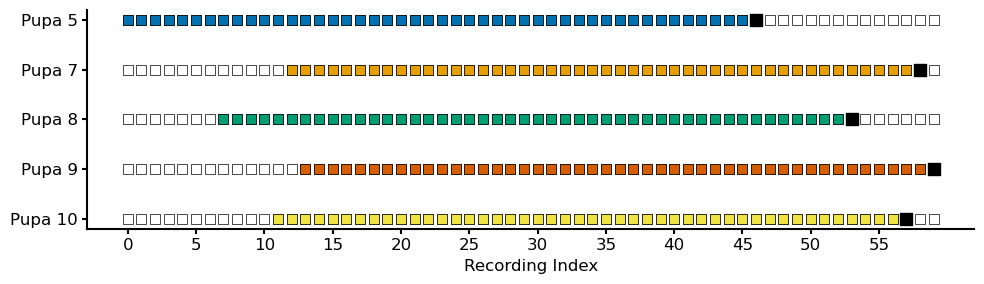

In [6]:
plt.figure(figsize=(10, 3))

# Prepare reversed lists so pupa_5 is on top
rev_pupae   = pupae[::-1]
rev_indices = included_indices[::-1]

n_v = 60
for row_idx, pupa in enumerate(rev_pupae):
    # 1) draw a full row of white squares with black border
    xs = np.arange(n_v)
    ys = np.full(n_v, row_idx)
    plt.scatter(
        xs, ys,
        marker='s', s=50,
        facecolors='white', edgecolors='black', linewidths=0.5,
        label='_nolegend_'  # skip legend
    )

    # 2) overlay colored squares for included recordings
    recs = rev_indices[row_idx]
    plt.scatter(
        recs, np.full_like(recs, row_idx),
        marker='s', s=50,
        facecolors=pupa_colors[pupa], edgecolors='black', linewidths=0.5,
        label='_nolegend_'
    )

    # 3) black square at hatch time (end_idx + 1)
    _, end_idx = inclusion[pupa]
    hatch_frame = end_idx + 1
    plt.scatter(
        hatch_frame, row_idx,
        marker='s', s=70,
        facecolors='black', edgecolors='black',
        label='_nolegend_'
    )

pupa_names = ["Pupa 5", "Pupa 7", "Pupa 8", "Pupa 9", "Pupa 10"]
# tidy up
plt.yticks(range(len(rev_pupae)), pupa_names[::-1])
plt.xticks(np.arange(0, n_v, 5))
plt.xlabel("Recording Index")
# plt.title("Recordings Included per Pupa Until Eclosion")
plt.legend(loc='upper right', ncol=2, frameon=False)
plt.tight_layout()
plt.show()


## Accessory heart muscle traces analysis

C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2887880294.py:257: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression='c', nlags='auto')
C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2887880294.py:257: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression='c', nlags='auto')
C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2887880294.py:257: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression='c', nlags='auto')


Summary stat tests:
Peak rate:      ADF p=0.923, KPSS p=0.010, slope=0.024, p=2.08e-21
Rising slopes:  ADF p=0.575, KPSS p=0.010, slope=1.416, p=6.57e-20
Freq (Hz):      ADF p=0.858, KPSS p=0.010, slope=0.036, p=4.23e-26


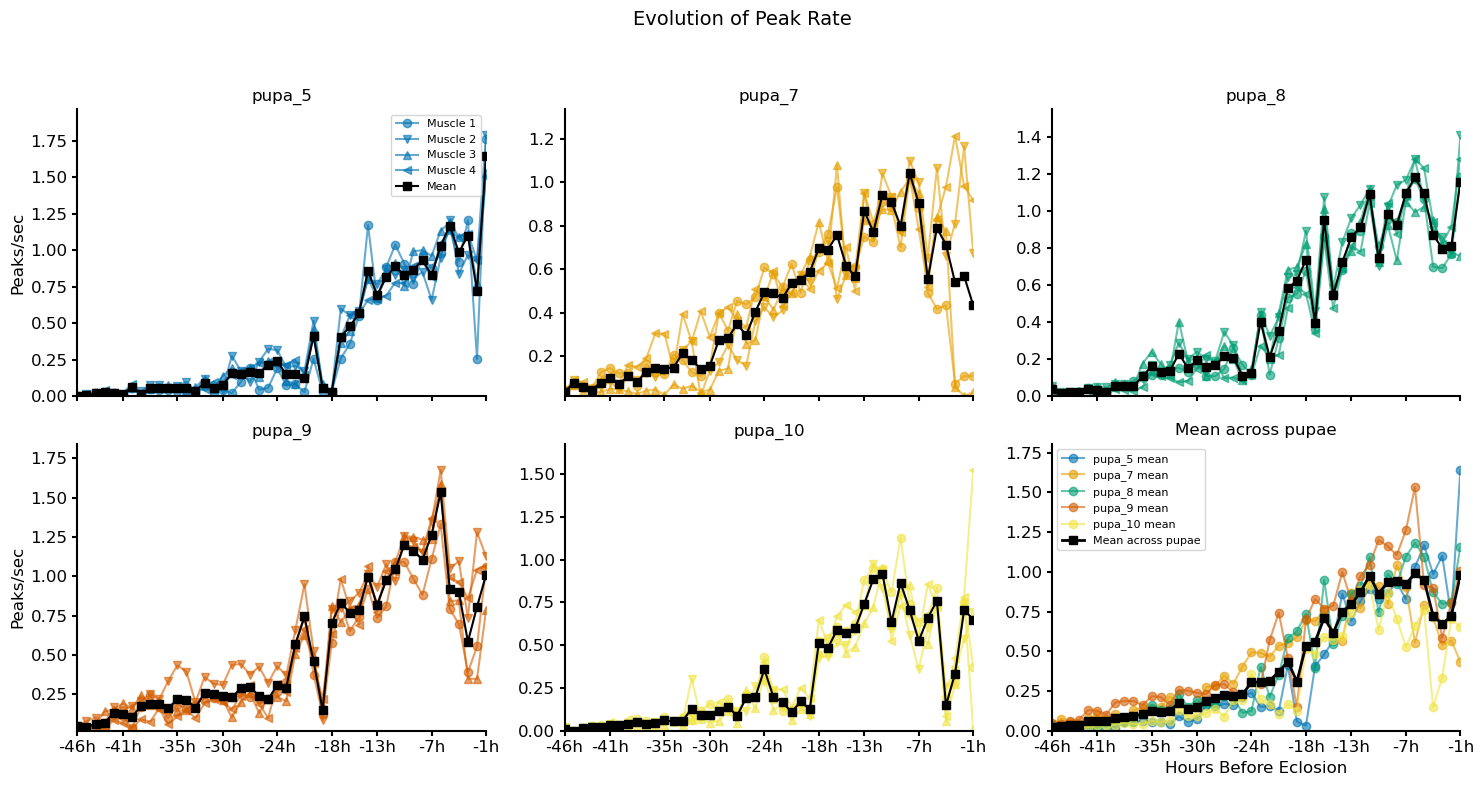

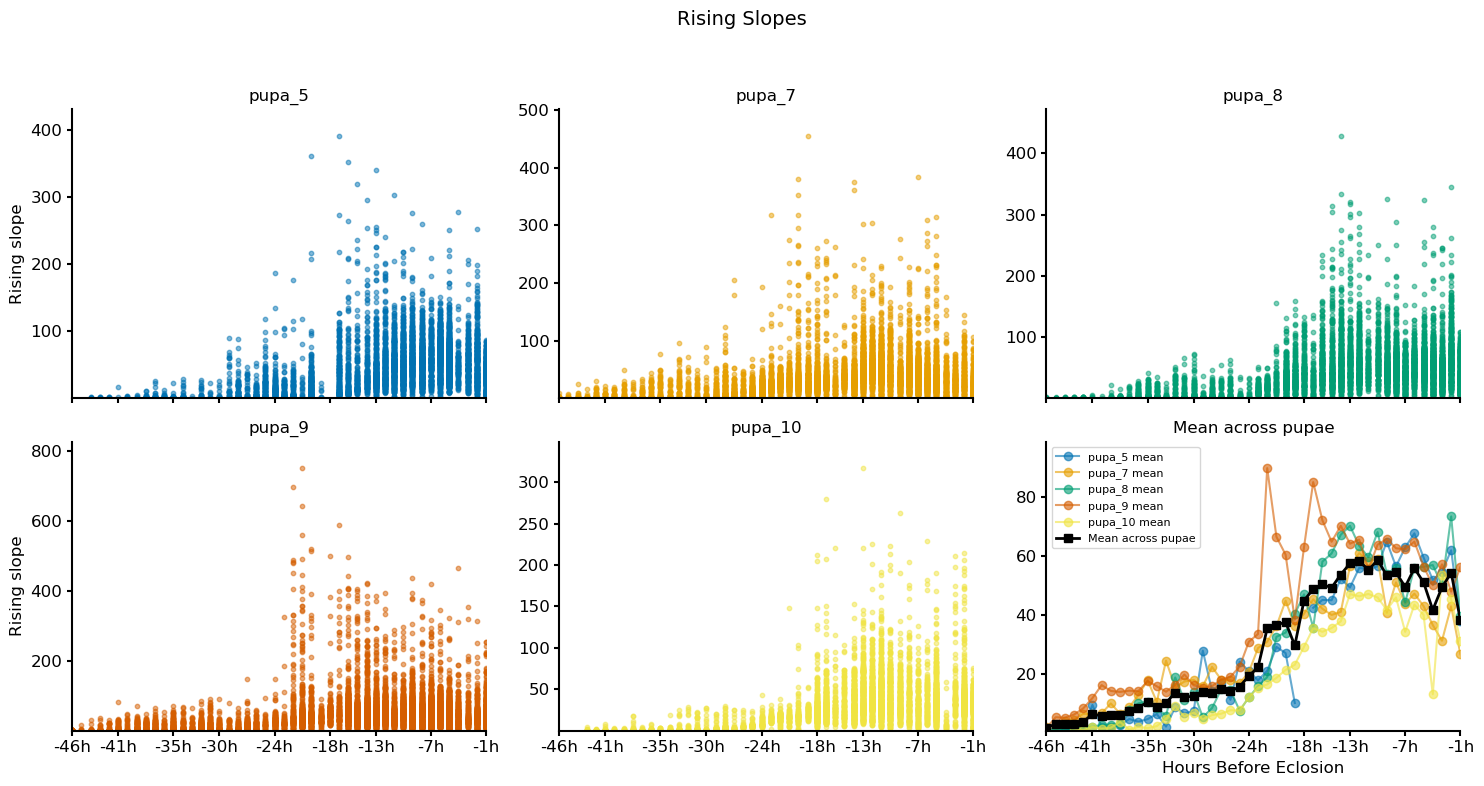

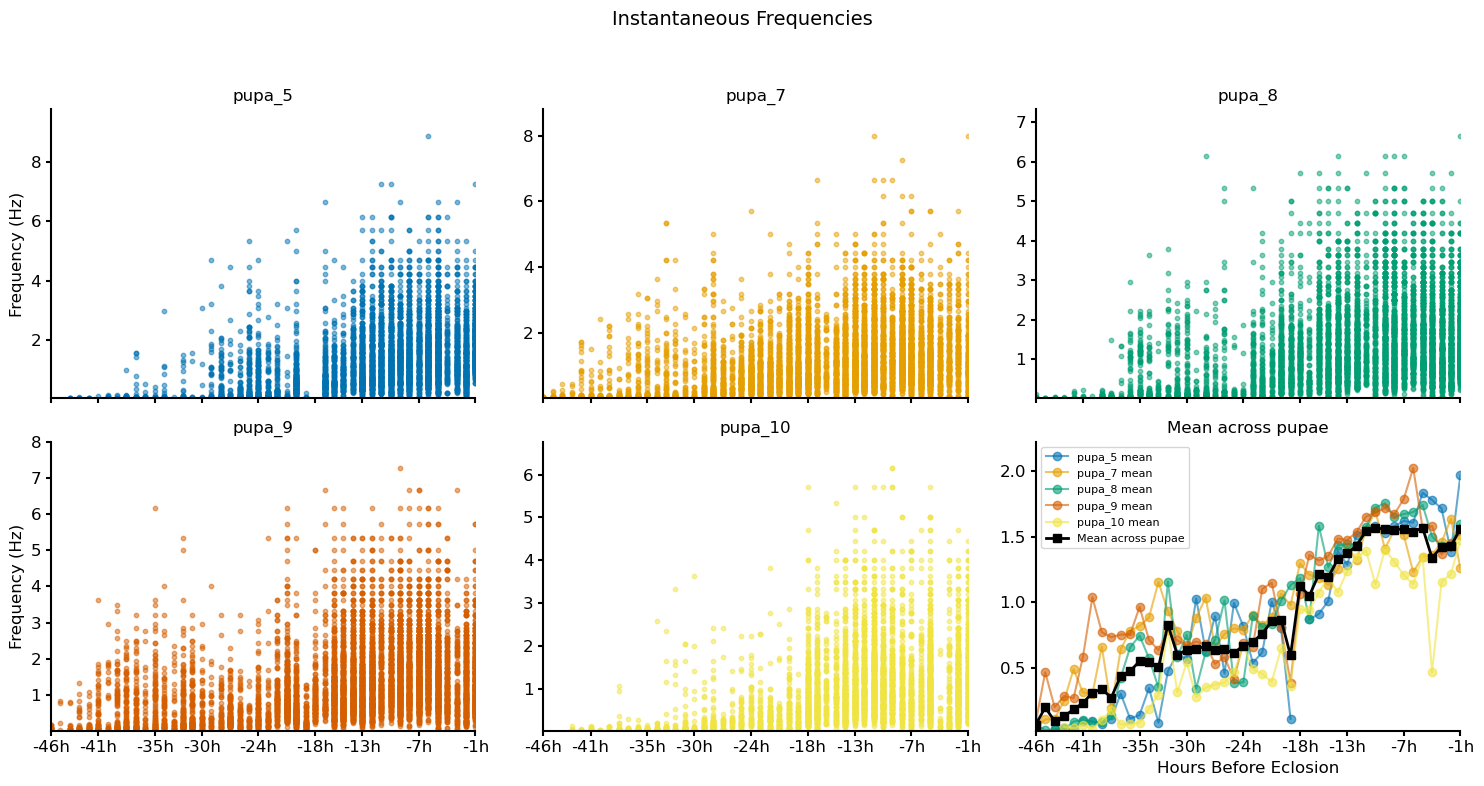

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

fs = 80.0
muscle_labels = ['Muscle 1','Muscle 2','Muscle 3','Muscle 4']
n_pupae = len(pupae)

# precompute tick positions & labels for hours-before-hatch
N = max(len(m) for m in all_m_t)  # should be equal across pupae once filtered
n_ticks = 9
tick_locs   = np.linspace(0, N-1, n_ticks, dtype=int)
tick_labels = [f"{-(N - loc)}h" for loc in tick_locs]

# helper to get metrics per pupa
def compute_metrics(muscle_traces):
    n_videos  = len(muscle_traces)
    n_muscles = len(muscle_traces[0])
    videos    = np.arange(n_videos)

    # allocate
    peak_rate  = np.zeros((n_videos, n_muscles))
    slopes_all = [[None]*n_muscles for _ in range(n_videos)]
    freqs_all  = [[None]*n_muscles for _ in range(n_videos)]

    for vid_idx, traces in enumerate(muscle_traces):
        for m_idx, trace in enumerate(traces):
            peaks, _  = find_peaks(trace, prominence=2, width=8,
                                   rel_height=0.5, distance=8)
            peak_rate[vid_idx,m_idx] = len(peaks)/(len(trace)/fs)

            if len(peaks)>=2:
                w, _, left_ips, _ = peak_widths(trace, peaks, rel_height=0.5)
                left_idxs = np.round(left_ips).astype(int)
                amp_peak  = trace[peaks]
                amp_left  = trace[left_idxs]
                t_peak    = peaks/fs
                t_left    = left_idxs/fs

                slopes_all[vid_idx][m_idx] = (amp_peak-amp_left)/(t_peak-t_left)
                freqs_all[vid_idx][m_idx]  = 1.0/np.diff(peaks/fs)

    return videos, peak_rate, slopes_all, freqs_all

# compute all pupae metrics
all_metrics = [compute_metrics(mt) for mt in all_m_t]

# 1) EVOLUTION OF PEAK RATE
fig1, axes1 = plt.subplots(2,3, figsize=(15,8), sharex=True)  # Removed sharey=True
axes1 = axes1.flatten()
markers = ['o','v','^','<']  # one marker per muscle (4 muscles)

for i, (pupa, (videos, pr, *_)) in enumerate(zip(pupae, all_metrics)):
    ax = axes1[i]
    # each muscle trace
    for m in range(pr.shape[1]):
        ax.plot(videos, pr[:,m],
                marker=markers[m], linestyle='-',
                color=pupa_colors[pupa], alpha=0.6,
                label=f'{muscle_labels[m]}')
    # this pupa's mean
    mean_pr = pr.mean(axis=1)
    ax.plot(videos, mean_pr,
            marker='s', linestyle='-', color='black', label='Mean')  # Changed to solid line
    
    # Set y-axis limits based on this subplot's data
    y_min = np.min(pr) * 0.9
    y_max = np.max(pr) * 1.1
    ax.set_ylim(y_min, y_max)
    
    ax.set_title(pupa)
    if i%3==0: ax.set_ylabel('Peaks/sec')
    ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
    ax.set_xlim(0, N-1)
    if i==0: ax.legend(fontsize=8, loc='best')

# summary panel
ax = axes1[-1]
# plot each pupa's mean
for pupa, (_, pr, *_ ) in zip(pupae, all_metrics):
    mean_pr = pr.mean(axis=1)
    ax.plot(videos, mean_pr,
            marker='o', linestyle='-',
            color=pupa_colors[pupa], alpha=0.6,
            label=f'{pupa} mean')
# plot grand mean across pupae
grand_mean = np.mean([pr.mean(axis=1) for (_, pr, _, _) in all_metrics], axis=0)
ax.plot(videos, grand_mean,
        marker='s', linestyle='-', color='black', lw=2, label='Mean across pupae')  # Changed to solid line

# Set y-axis limits for summary panel
y_min = np.min([pr.mean(axis=1) for (_, pr, _, _) in all_metrics]) * 0.9
y_max = np.max([pr.mean(axis=1) for (_, pr, _, _) in all_metrics]) * 1.1
ax.set_ylim(y_min, y_max)

ax.set_title('Mean across pupae')
ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
ax.set_xlim(0, N-1)
ax.set_xlabel('Hours Before Eclosion')
ax.legend(fontsize=8, loc='best')

plt.suptitle('Evolution of Peak Rate', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])


# 2) RISING SLOPE SCATTER (same panels) + summary w/ own y‑axis + black SOLID mean line
fig2, axes2 = plt.subplots(2,3, figsize=(15,8), sharex=True)  # Removed sharey=True
axes2 = axes2.flatten()
for i, (pupa, (videos, _, slopes_all, *_)) in enumerate(zip(pupae, all_metrics)):
    ax = axes2[i]
    all_slopes = []
    for v in videos:
        valid = [slopes_all[v][m] for m in range(len(slopes_all[v]))
                 if slopes_all[v][m] is not None and slopes_all[v][m].size>0]
        if not valid: continue
        y = np.hstack(valid)
        all_slopes.extend(y)
        ax.scatter(np.full_like(y, v), y,
                   color=pupa_colors[pupa], s=10, alpha=0.5)
    
    # Set y-axis limits based on this subplot's data
    if all_slopes:
        y_min = np.min(all_slopes) * 0.9
        y_max = np.max(all_slopes) * 1.1
        ax.set_ylim(y_min, y_max)
    
    ax.set_title(pupa)
    if i%3==0: ax.set_ylabel('Rising slope')
    ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
    ax.set_xlim(0, N-1)

# summary panel
ax = axes2[-1]
# per‑pupa MEAN slopes (changed from median)
all_means = []
for pupa, (_, _, slopes_all, *_ ) in zip(pupae, all_metrics):
    mean_slopes = [
        np.mean(np.hstack([slopes_all[v][m] 
                           for m in range(len(slopes_all[v])) 
                           if slopes_all[v][m] is not None and slopes_all[v][m].size>0]))
        if any(slopes_all[v][m] is not None and slopes_all[v][m].size>0 
               for m in range(len(slopes_all[v]))) 
        else np.nan
        for v in videos
    ]
    all_means.append(mean_slopes)
    ax.plot(videos, mean_slopes,
            marker='o', linestyle='-',
            color=pupa_colors[pupa], alpha=0.6,
            label=f'{pupa} mean')  # Added label for each pupa

# grand MEAN across pupae (changed from median)
all_means_array = np.vstack([
    [np.mean(np.hstack([slopes_all[v][m] 
                        for m in range(len(slopes_all[v])) 
                        if slopes_all[v][m] is not None and slopes_all[v][m].size>0]))
     if any(slopes_all[v][m] is not None and slopes_all[v][m].size>0 
            for m in range(len(slopes_all[v]))) else np.nan
     for v in videos]
    for (_, _, slopes_all, _) in all_metrics
])
grand_mean_slopes = np.nanmean(all_means_array, axis=0)
ax.plot(videos, grand_mean_slopes,
        marker='s', linestyle='-', color='black', lw=2, label='Mean across pupae')  # Changed to solid line

ax.set_title('Mean across pupae')  # Changed from Median to Mean
ax.set_ylim(np.nanmin(all_means_array)*0.9, np.nanmax(all_means_array)*1.1)
ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
ax.set_xlim(0, N-1)
ax.set_xlabel('Hours Before Eclosion')
ax.legend(fontsize=8, loc='best')

plt.suptitle('Rising Slopes', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])


# 3) INSTANTANEOUS FREQUENCIES (same panels) + summary w/ own y‑axis + black SOLID mean line
fig3, axes3 = plt.subplots(2,3, figsize=(15,8), sharex=True)  # Removed sharey=True
axes3 = axes3.flatten()
for i, (pupa, (videos, *_, freqs_all)) in enumerate(zip(pupae, all_metrics)):
    ax = axes3[i]
    all_freqs_subplot = []
    for v in videos:
        valid = [freqs_all[v][m] for m in range(len(freqs_all[v]))
                 if freqs_all[v][m] is not None and freqs_all[v][m].size>0]
        if not valid: continue
        y = np.hstack(valid)
        all_freqs_subplot.extend(y)
        ax.scatter(np.full_like(y, v), y,
                   color=pupa_colors[pupa], s=10, alpha=0.5)
    
    # Set y-axis limits based on this subplot's data
    if all_freqs_subplot:
        y_min = np.min(all_freqs_subplot) * 0.9
        y_max = np.max(all_freqs_subplot) * 1.1
        ax.set_ylim(y_min, y_max)
    
    ax.set_title(pupa)
    if i%3==0: ax.set_ylabel('Frequency (Hz)')
    ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
    ax.set_xlim(0, N-1)

# summary panel
ax = axes3[-1]
all_means_freq = []
for pupa, (videos, *_, freqs_all) in zip(pupae, all_metrics):
    # Changed to MEAN from median
    mean_freqs = [
        np.mean(np.hstack([freqs_all[v][m]
                           for m in range(len(freqs_all[v]))
                           if freqs_all[v][m] is not None and freqs_all[v][m].size>0]))
        if any(freqs_all[v][m] is not None and freqs_all[v][m].size>0
               for m in range(len(freqs_all[v]))) else np.nan
        for v in videos
    ]
    all_means_freq.append(mean_freqs)
    ax.plot(videos, mean_freqs,
            marker='o', linestyle='-',
            color=pupa_colors[pupa], alpha=0.6,
            label=f'{pupa} mean')  # Added label for each pupa

# grand MEAN freq (changed from median)
all_freqs_array = np.vstack([
    [np.mean(np.hstack([freqs_all[v][m]
                       for m in range(len(freqs_all[v]))
                       if freqs_all[v][m] is not None and freqs_all[v][m].size>0]))
     if any(freqs_all[v][m] is not None and freqs_all[v][m].size>0 
            for m in range(len(freqs_all[v]))) else np.nan
     for v in videos]
    for (_, *_, freqs_all) in all_metrics
])
grand_freq_mean = np.nanmean(all_freqs_array, axis=0)  # Changed to mean
ax.plot(videos, grand_freq_mean,
        marker='s', linestyle='-', color='black', lw=2, label='Mean across pupae')  # Changed to solid line

ax.set_title('Mean across pupae')  # Changed from Median to Mean
ax.set_ylim(np.nanmin(all_freqs_array)*0.9, np.nanmax(all_freqs_array)*1.1)
ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
ax.set_xlim(0, N-1)
ax.set_xlabel('Hours Before Eclosion')
ax.legend(fontsize=8, loc='best')

plt.suptitle('Instantaneous Frequencies', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])


from statsmodels.tsa.stattools import adfuller, kpss

# 4) STATISTICAL TESTS ON SUMMARY SERIES - Now with KPSS
def adf_kpss_slope(y, t):
    # ADF
    adf_stat, adf_p, *_ = adfuller(y, regression='c', autolag='AIC')
    # KPSS (null = stationary around trend)
    kpss_stat, kpss_p, *_ = kpss(y, regression='c', nlags='auto')
    # OLS slope
    X = sm.add_constant(t)
    m = sm.OLS(y, X).fit()
    return adf_p, kpss_p, m.params[1], m.pvalues[1]

# a) peak rate summary
adf_pr, kpss_pr, slope_pr, p_pr = adf_kpss_slope(grand_mean, videos)
# b) rising slopes summary
adf_rs, kpss_rs, slope_rs, p_rs = adf_kpss_slope(grand_mean_slopes, videos)
# c) frequency summary
adf_fr, kpss_fr, slope_fr, p_fr = adf_kpss_slope(grand_freq_mean, videos)

print("Summary stat tests:")
print(f"Peak rate:      ADF p={adf_pr:.3f}, KPSS p={kpss_pr:.3f}, slope={slope_pr:.3f}, p={p_pr:.2e}")
print(f"Rising slopes:  ADF p={adf_rs:.3f}, KPSS p={kpss_rs:.3f}, slope={slope_rs:.3f}, p={p_rs:.2e}")
print(f"Freq (Hz):      ADF p={adf_fr:.3f}, KPSS p={kpss_fr:.3f}, slope={slope_fr:.3f}, p={p_fr:.2e}")


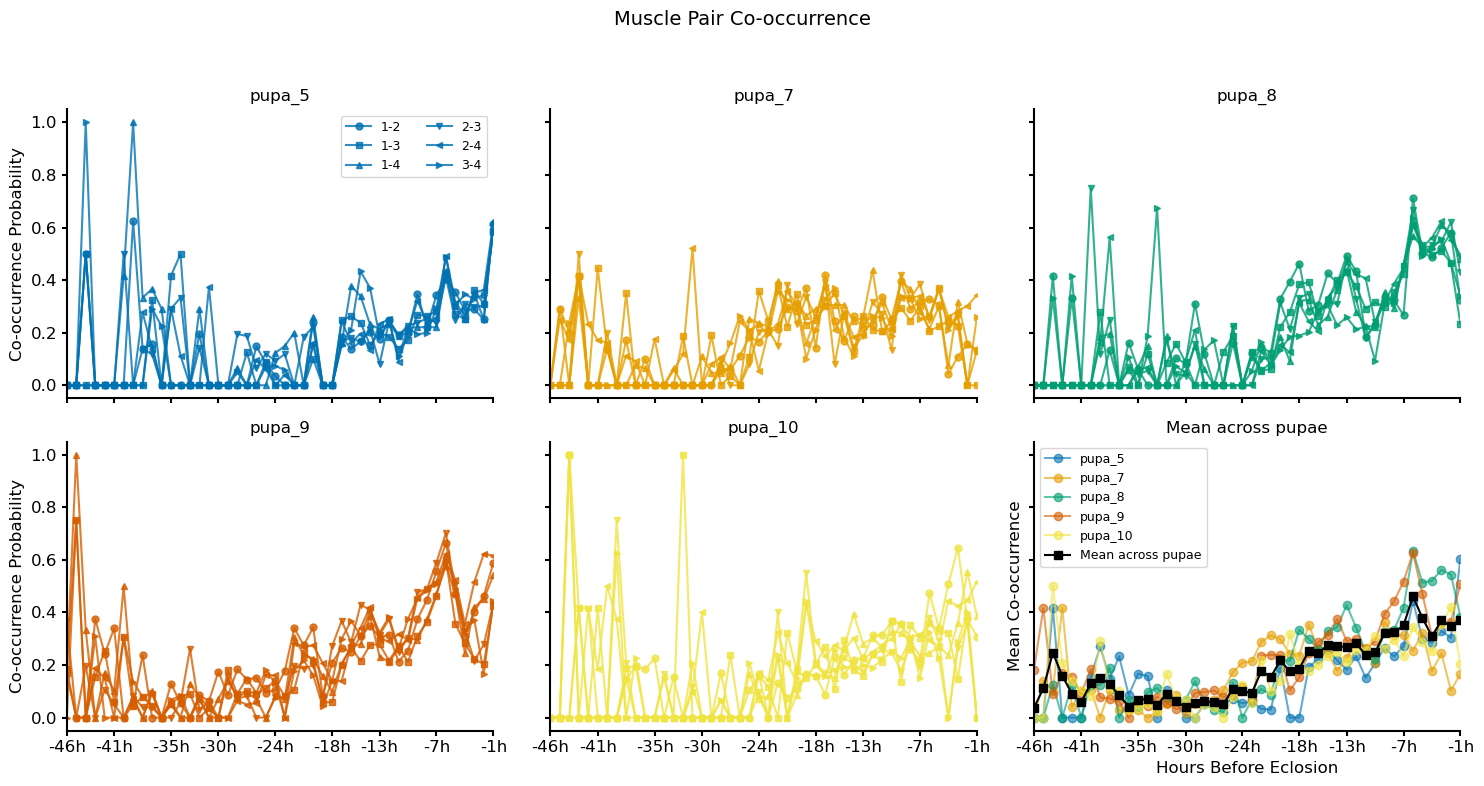

Grand‑mean co‑occurrence:
  ADF p = 0.985  (null: unit root)
  KPSS p = 0.010 (null: stationary)
  Trend slope = 0.007, p = 5.63e-12


C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\3131654529.py:133: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(grand_mean_cooc, regression='c', nlags="auto")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

fs = 80.0
pair_markers = ['o', 's', '^', 'v', '<', '>']

# precompute all pupae co-occurrence
all_coocs = []
for pupa, m_t in zip(pupae, all_m_t):
    vids, pair_labels, cooc = utils.event_cooccurrence_from_traces(m_t)
    all_coocs.append((vids, pair_labels, cooc))

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()

# panels 1–5: per‐pupa
for i, (pupa, (videos, pair_labels, cooc)) in enumerate(zip(pupae, all_coocs)):
    ax = axes[i]
    for k, lbl in enumerate(pair_labels):
        ax.plot(
            videos,
            cooc[:, k],
            marker=pair_markers[k],
            linestyle='-',
            markersize=5,
            color=pupa_colors[pupa],
            alpha=0.8,
            label=lbl if i==0 else None
        )
    ax.set_title(pupa)
    if i % 3 == 0:
        ax.set_ylabel("Co‑occurrence Probability")
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels)
    ax.set_xlim(0, len(videos)-1)
    if i == 0:
        ax.legend(ncol=2, fontsize=9)


import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

fs = 80.0
pair_markers = ['o', 's', '^', 'v', '<', '>']

# … [event_cooccurrence_from_traces and panels 1–5 unchanged] …

# panel 6: mean across pupae + grand mean + legend entry
ax = axes[-1]
per_pupa_means = []
for pupa, (_, pair_labels, cooc) in zip(pupae, all_coocs):
    mean_cooc = cooc.mean(axis=1)
    per_pupa_means.append(mean_cooc)
    ax.plot(
        videos,
        mean_cooc,
        marker='o',
        linestyle='-',
        markersize=6,
        label=pupa,
        color=pupa_colors[pupa],
        alpha=0.6
    )

grand_mean_cooc = np.mean(per_pupa_means, axis=0)
ax.plot(
    videos,
    grand_mean_cooc,
    marker='s',
    linestyle='-',
    markersize=6,
    color='black',
    label='Mean across pupae'
)

ax.set_title("Mean across pupae")
ax.set_ylabel("Mean Co‑occurrence")
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.set_xlim(0, len(videos)-1)
ax.set_xlabel("Hours Before Eclosion")
ax.legend(fontsize=9)

fig.suptitle("Muscle Pair Co‑occurrence", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ——————————————————————————————————————————————————————————————
# 4) STATISTICAL TEST ON GRAND MEAN SERIES
# ——————————————————————————————————————————————————————————————

# 4a) Augmented Dickey–Fuller (null = unit root)
adf_stat, adf_p, *_ = adfuller(grand_mean_cooc, regression='c', autolag='AIC')

# 4b) KPSS (null = stationarity around trend)
kpss_stat, kpss_p, _, _ = kpss(grand_mean_cooc, regression='c', nlags="auto")

# 4c) Linear OLS trend: grand_mean_cooc ~ 1 + t
t = videos
X = sm.add_constant(t)
model = sm.OLS(grand_mean_cooc, X).fit()
slope   = model.params[1]
slope_p = model.pvalues[1]

print(f"Grand‑mean co‑occurrence:\n"
      f"  ADF p = {adf_p:.3f}  (null: unit root)\n"
      f"  KPSS p = {kpss_p:.3f} (null: stationary)\n"
      f"  Trend slope = {slope:.3f}, p = {slope_p:.2e}")


## Overall muscle activity analysis

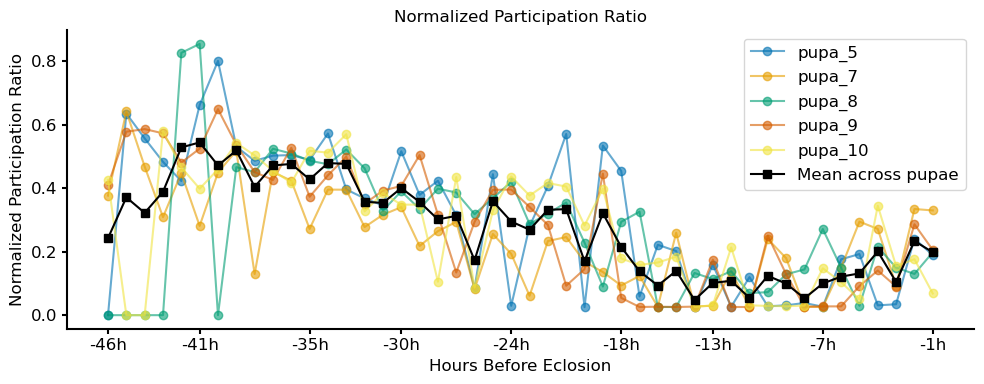

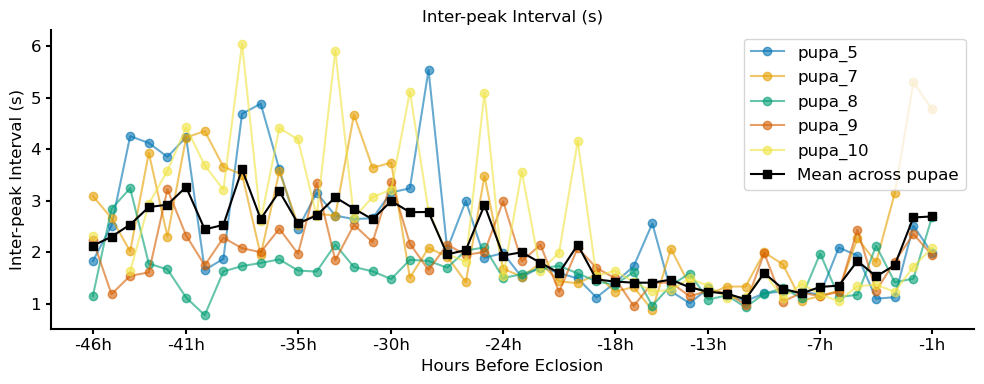

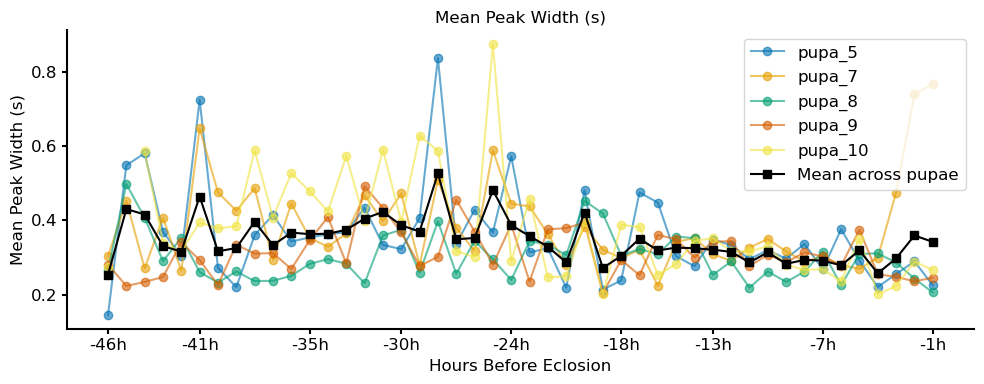

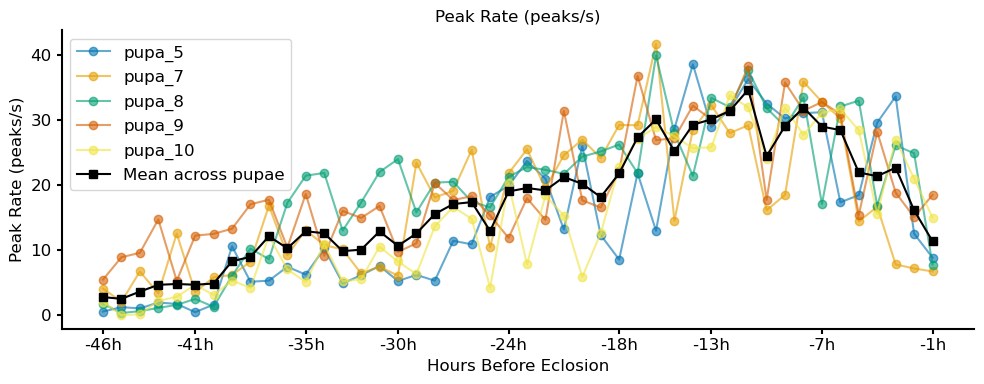

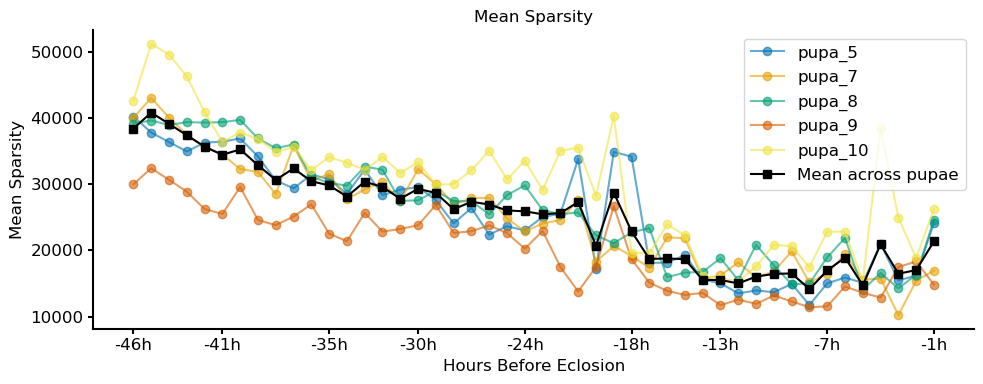

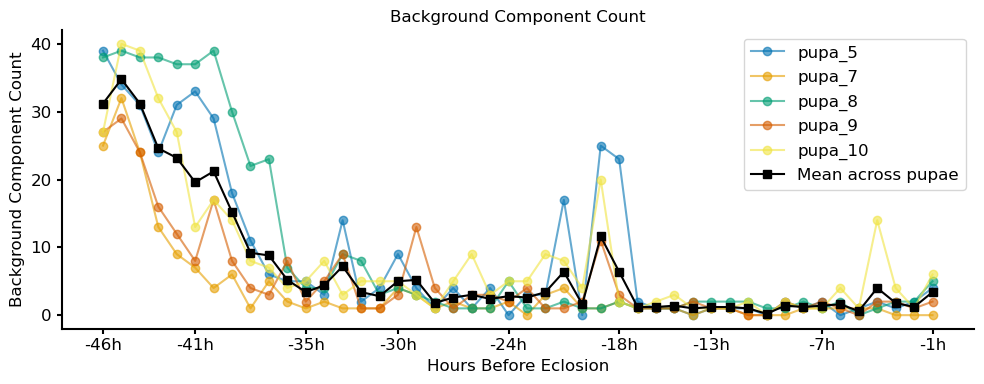

In [ ]:

fs = 80.0
n = len(nmfs)
idx = np.arange(n)

# Containers: metrics[pupa][metric_name] = list of length n
metric_names = ["PR", "IPI", "WIDTH", "RATE", "SP", "BG_COUNT"]
metrics = {p: {m: [] for m in metric_names} for p in pupae}

for pupa, nmfs in zip(pupae, all_nmfs):
    bg_sparsity_thr = bg_sparsity_thrs[pupa]
    for v in idx:
        H_stack, W = nmfs[v]
        # spatial sparsity per component
        sparsities = np.array([utils.comp_sparsity(H_stack[i]) for i in range(H_stack.shape[0])])
        # define background sparsity threshold on lower value of the first video
        bg_idx = np.where(sparsities > bg_sparsity_thr)[0]
        fg_idx = np.where(sparsities <= bg_sparsity_thr)[0]

        # BG count & mean sparsity
        metrics[pupa]["BG_COUNT"].append(len(bg_idx))
        metrics[pupa]["SP"].append(np.nanmean(sparsities))

        # temporal on foreground only
        W_fg = W[:, fg_idx]
        metrics[pupa]["PR"].append(
            (utils.participation_ratio(W_fg)/W_fg.shape[1]) if W_fg.shape[1] > 2 else 0.0
        )
        metrics[pupa]["IPI"].append(utils.mean_ipi(W_fg))
        metrics[pupa]["WIDTH"].append(utils.mean_peak_width(W_fg,fs=80, rel_height=0.5))
        metrics[pupa]["RATE"].append(utils.peak_rate(W_fg))

# ---- now plot each metric across pupae ----
for name in ["PR", "IPI", "WIDTH", "RATE", "SP", "BG_COUNT"]:
    plt.figure(figsize=(10,4))
    for pupa in pupae:
        plt.plot(idx,
                 metrics[pupa][name],
                 marker='o',
                 alpha=0.6,
                 label=pupa,
                 color=pupa_colors[pupa])
    all_data = np.vstack([metrics[p][name] for p in pupae])
    mean_curve = np.nanmean(all_data, axis=0)
    plt.plot(idx, mean_curve,
           marker='s', color='black', linestyle='-',
           label='Mean across pupae', linewidth=1.5)

    plt.xticks(tick_locs, tick_labels)
    plt.xlabel("Hours Before Eclosion")
    ylabel = {
        "PR":    "Normalized Participation Ratio",
        "IPI":   "Inter-peak Interval (s)",
        "WIDTH": "Mean Peak Width (s)",
        "RATE":  "Peak Rate (peaks/s)",
        "SP":    "Mean Sparsity",
        "BG_COUNT": "Background Component Count"
    }[name]
    plt.ylabel(ylabel)
    plt.title(f"{ylabel}")
    plt.legend()
    plt.tight_layout()
    plt.show()


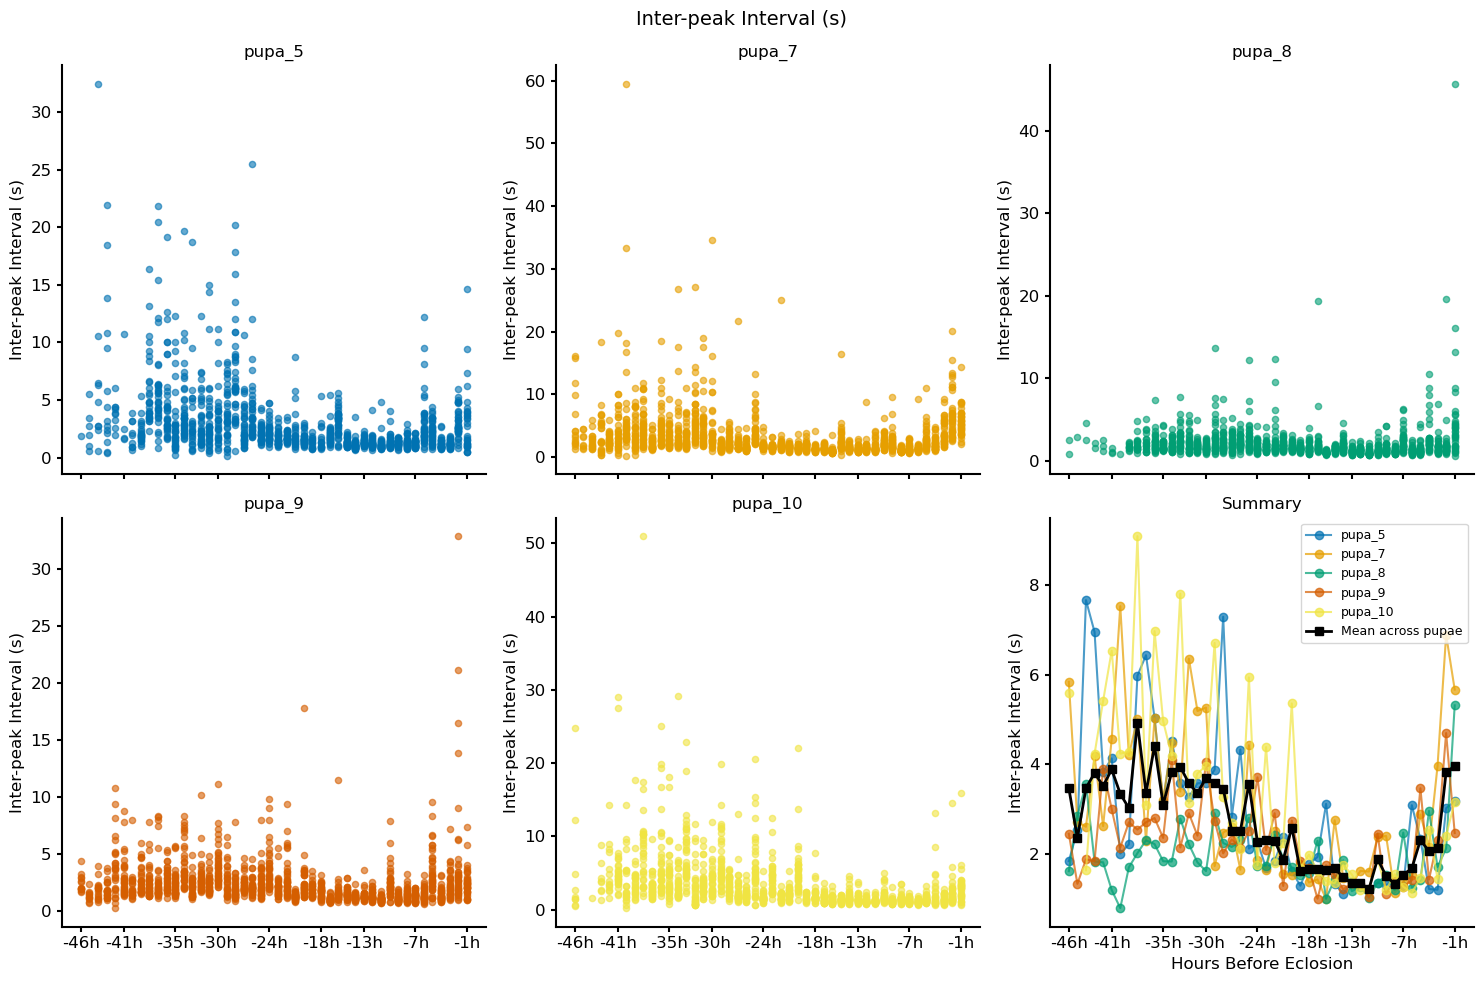

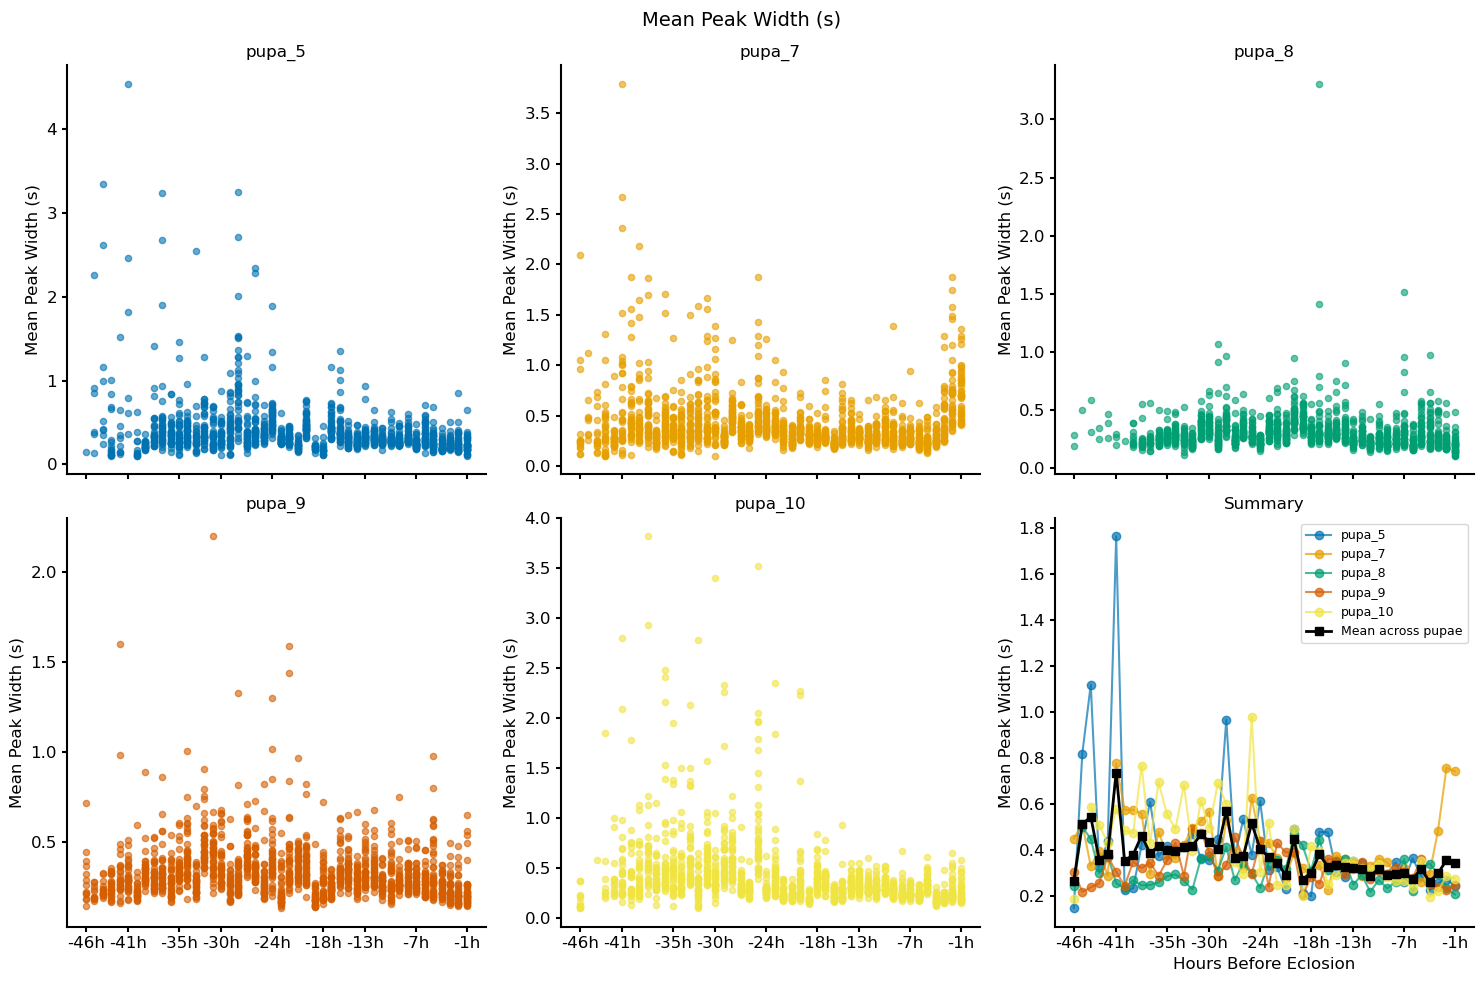

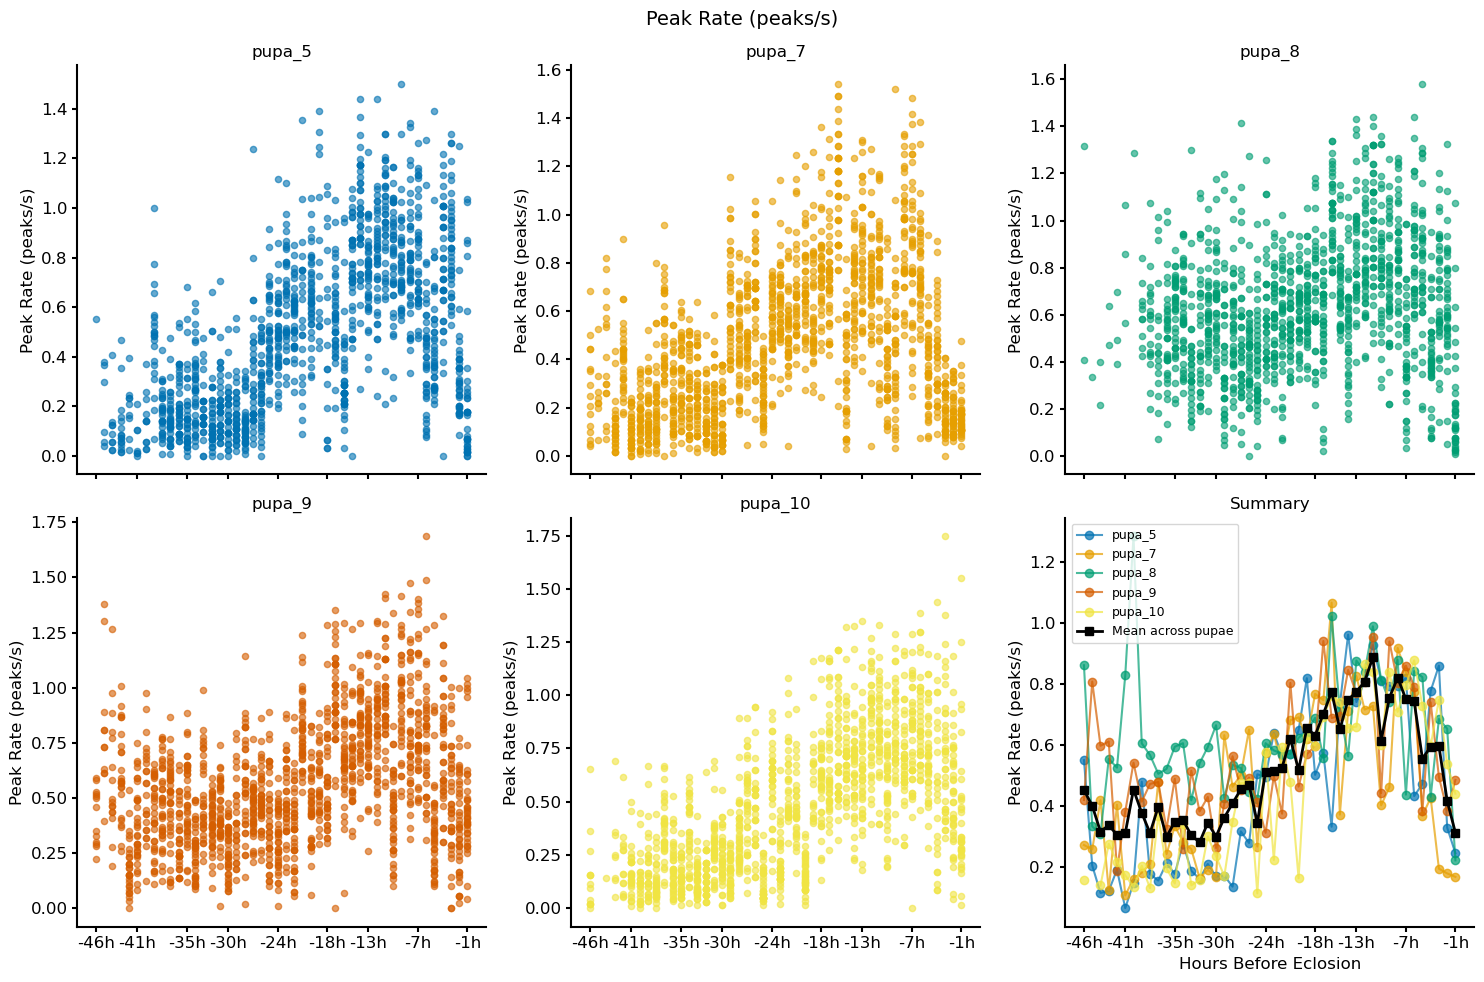

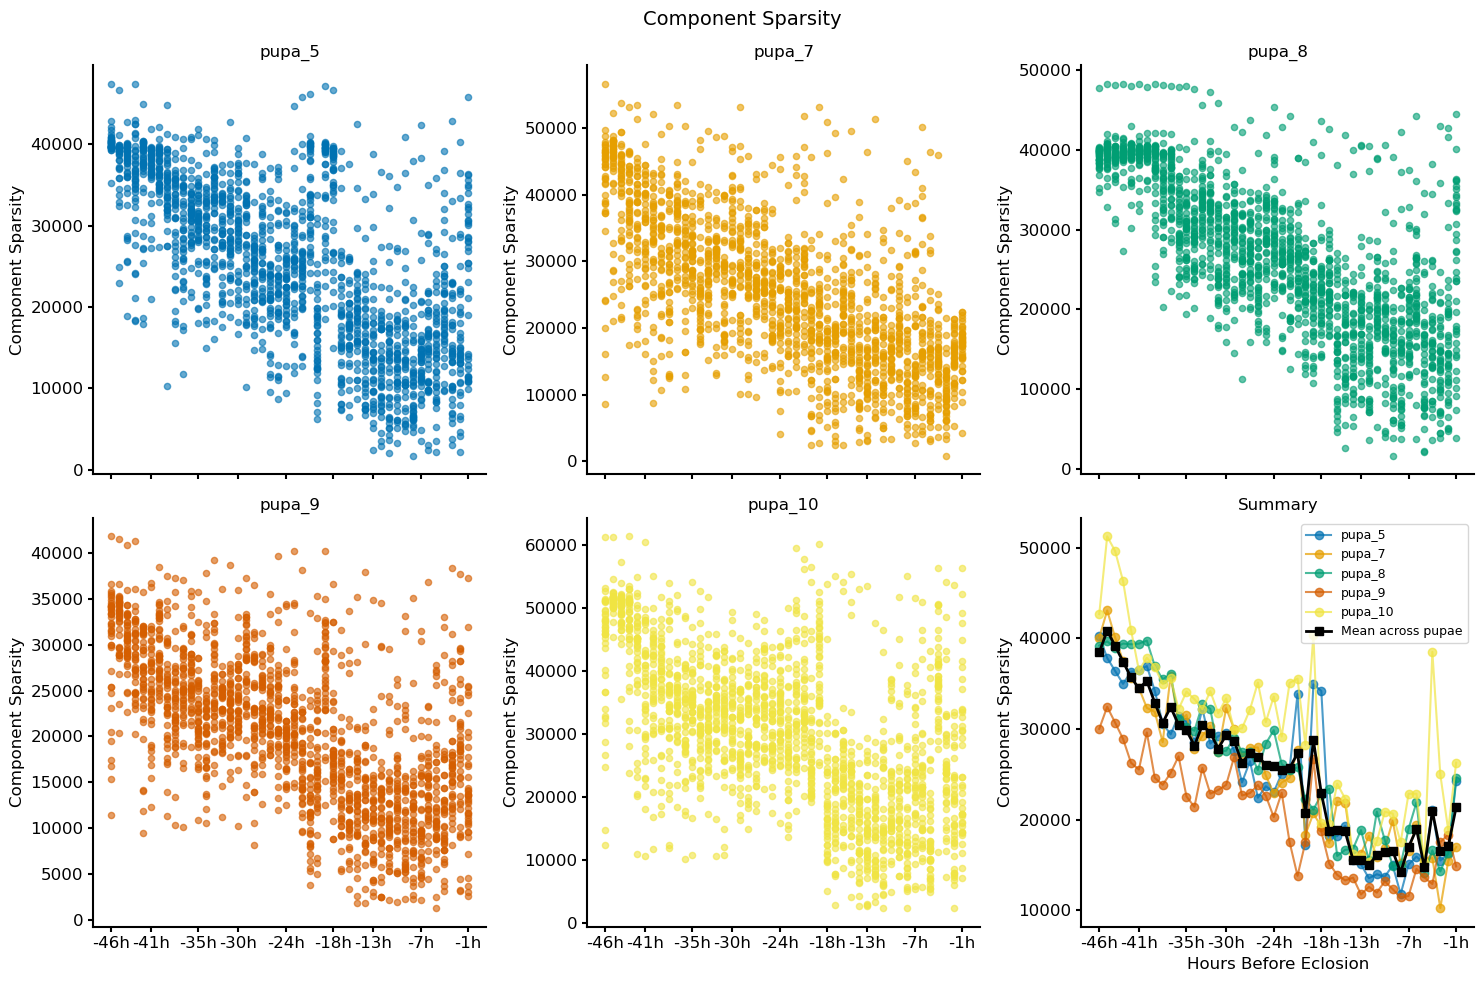

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from skimage.measure import label, regionprops


fs = 80.0

# --- 1) Build detail_metrics ---
metric_names = ["PR","IPI","WIDTH","RATE","SP","BG_COUNT"]
detail_metrics = {
    name: {p: [[] for _ in range(len(all_nmfs[0]))] for p in pupae}
    for name in metric_names
}

for pupa, nmfs in zip(pupae, all_nmfs):
    bg_thr = bg_sparsity_thrs[pupa]
    for t, (H_stack, W) in enumerate(nmfs):
        # SP
        sparsities = [utils.comp_sparsity(h) for h in H_stack]
        detail_metrics["SP"][pupa][t] = sparsities

        # BG_COUNT flag per component
        detail_metrics["BG_COUNT"][pupa][t] = [
            1 if s > bg_thr else 0 for s in sparsities
        ]

        # temporal metrics on each foreground component
        fg_idx = [i for i,s in enumerate(sparsities) if s<=bg_thr]
        for i in fg_idx:
            comp_w = W[:, i].reshape(-1,1)
            detail_metrics["PR"][pupa][t].append(utils.participation_ratio(comp_w))
            detail_metrics["IPI"][pupa][t].append(utils.mean_ipi(comp_w))
            detail_metrics["WIDTH"][pupa][t].append(
                utils.mean_peak_width(comp_w,fs=80, rel_height=0.5))
            detail_metrics["RATE"][pupa][t].append(utils.peak_rate(comp_w))

# --- 2) Compute per-pupa means ---
mean_per_pupa_metrics = {
    name: {
        p: np.array([
            np.nanmean(detail_metrics[name][p][t]) 
            if detail_metrics[name][p][t] else np.nan
            for t in idx
        ])
        for p in pupae
    }
    for name in metric_names
}

# --- 3) Plot in 2×3 grid ---
to_plot = ["IPI","WIDTH","RATE","SP"]
ylabels = {
    "IPI":"Inter-peak Interval (s)","WIDTH":"Mean Peak Width (s)",
    "RATE":"Peak Rate (peaks/s)","SP":"Component Sparsity"
}

for name in to_plot:
    fig, axes = plt.subplots(2,3,figsize=(15,10), sharex=True)
    axes = axes.flatten()

    # panels 0–4: scatter all values per pupa
    for ax, pupa in zip(axes[:5], pupae):
        for t, vals in enumerate(detail_metrics[name][pupa]):
            if vals:
                ax.scatter([t]*len(vals), vals,
                           color=pupa_colors[pupa],
                           alpha=0.6, s=20)
        ax.set_title(pupa); ax.grid(False)
        ax.set_ylabel(ylabels[name])

    # panel 5: line summary with means
    ax = axes[5]
    for pupa in pupae:
        ax.plot(idx, mean_per_pupa_metrics[name][pupa],
                marker='o', linestyle='-', color=pupa_colors[pupa],
                alpha=0.7, label=pupa)
    overall = np.nanmean([mean_per_pupa_metrics[name][p] for p in pupae],axis=0)
    ax.plot(idx, overall,
            marker='s', color='black', linestyle='-',
            linewidth=2, label='Mean across pupae')
    ax.set_title(f"Summary")
    ax.set_xticks(tick_locs); ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Hours Before Eclosion")
    ax.set_ylabel(ylabels[name])
    ax.legend(fontsize=9); ax.grid(False)
    plt.suptitle(f"{ylabels[name]}", fontsize=14)
    plt.tight_layout(); plt.show()


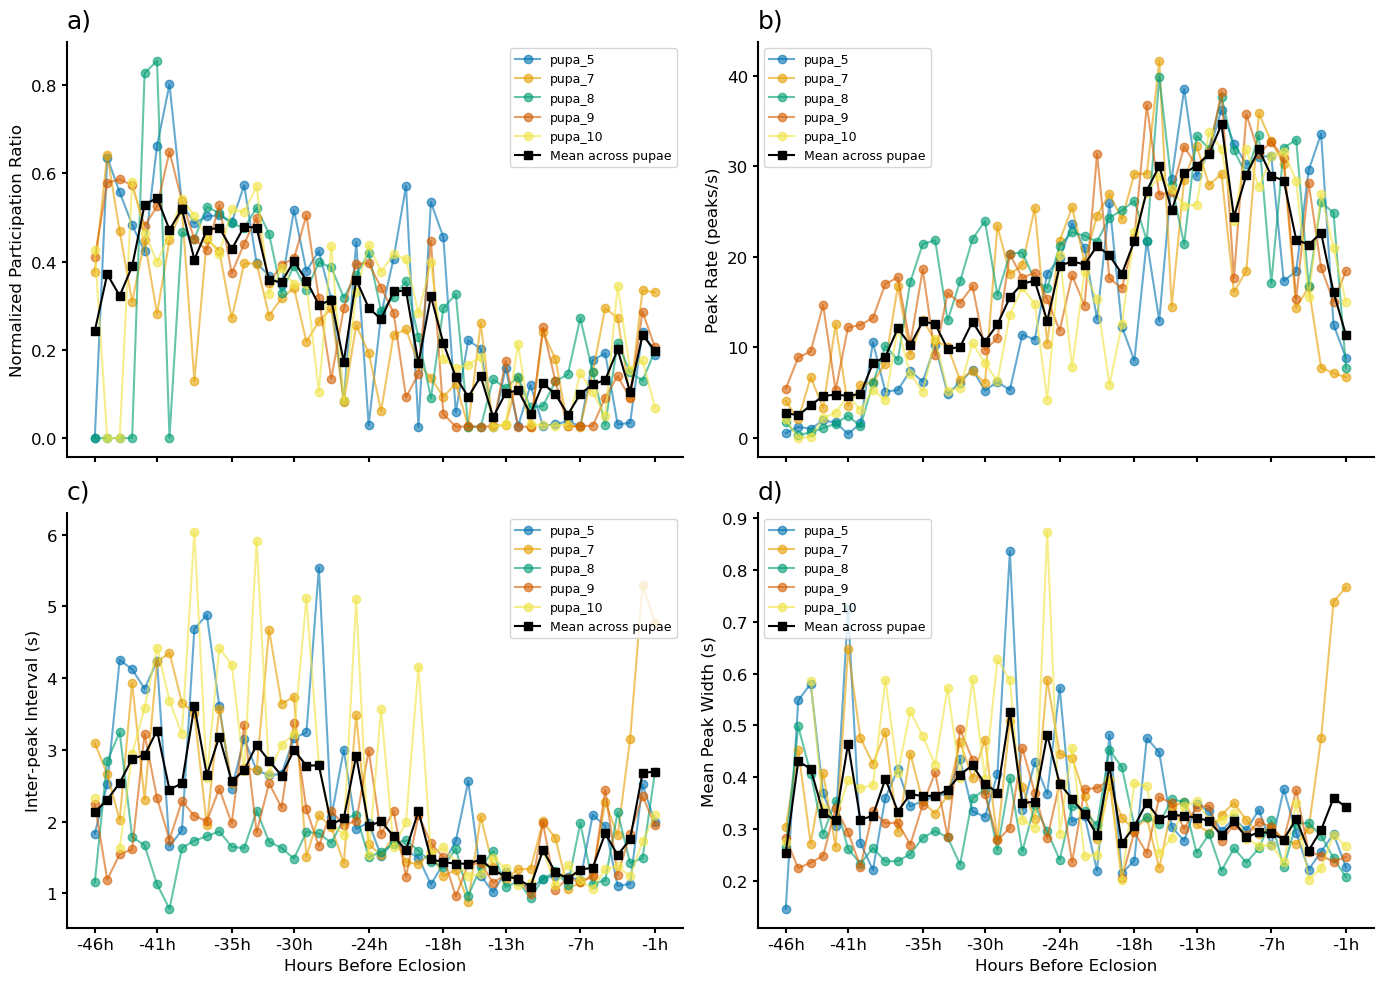

In [14]:
import numpy as np
import matplotlib.pyplot as plt

metrics_to_plot = ["PR","RATE", "IPI", "WIDTH"]
ylabels = {
    "PR":    "Normalized Participation Ratio",
    "IPI":   "Inter‑peak Interval (s)",
    "WIDTH": "Mean Peak Width (s)",
    "RATE":  "Peak Rate (peaks/s)"
}
letters = ['a)', 'b)', 'c)', 'd)']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, name, letter in zip(axes, metrics_to_plot, letters):
    # plot each pupa
    for pupa in pupae:
        ax.plot(idx,
                metrics[pupa][name],
                marker='o',
                linestyle='-',
                label=pupa,
                color=pupa_colors[pupa],
                alpha=0.6)

    # plot mean across pupae
    all_data   = np.vstack([metrics[p][name] for p in pupae])
    mean_curve = np.nanmean(all_data, axis=0)
    ax.plot(idx,
            mean_curve,
            marker='s',
            color='black',
            linestyle='-',
            linewidth=1.5,
            label='Mean across pupae')

    # axis formatting
    if ax in axes[2:]:
        ax.set_xlabel("Hours Before Eclosion")
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels)
    #only put x-labels on the bottom row
    
    ax.set_ylabel(ylabels[name])
    ax.set_title(letter, loc='left', pad=10, fontsize=18)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# 1) POOLED SERIES: take mean over pupae at each timepoint
metric_names = ["PR", "IPI", "WIDTH", "RATE", "SP", "BG_COUNT"]
n = len(next(iter(metrics.values()))["PR"])
t = np.arange(n)

pooled = {}
for metric in metric_names:
    arr = np.vstack([metrics[p][metric] for p in pupae])
    pooled[metric] = np.nanmean(arr, axis=0)

df = pd.DataFrame(pooled)
df['t'] = t

# 2) TEST FUNCTION: ADF + KPSS + OLS trend
def adf_kpss_trend(name, y, t_index):
    # ADF with intercept+trend
    adf_stat, adf_p, *_ = adfuller(y, regression='c', autolag='AIC')
    # KPSS with trend ("ct"), nlags="auto"
    kpss_stat, kpss_p, _, _ = kpss(y, regression='c', nlags="auto")
    # OLS slope test
    X = sm.add_constant(t_index)
    mod = sm.OLS(y, X).fit()
    slope  = mod.params[1]
    slope_p = mod.pvalues[1]
    return {
        "metric":  name,
        "adf_p":   adf_p,
        "kpss_p":  kpss_p,
        "slope":   slope,
        "slope_p": slope_p
    }

# 3) RUN FOR MONOTONIC METRICS
results = []
for name in ["PR", "IPI", "WIDTH", "SP", "BG_COUNT"]:
    y = df[name].values
    results.append(adf_kpss_trend(name, y, df['t']))

# 4) PIECEWISE FOR RATE @ knot=35
knot     = 35
y_rate   = df["RATE"].values
post35   = np.maximum(0, df['t'] - knot)

# 4a) stationarity tests on full RATE
adf_stat_r, adf_p_r, *_ = adfuller(y_rate, regression='c', autolag='AIC')
kpss_stat_r, kpss_p_r, _, _ = kpss(y_rate, regression='c', nlags="auto")

# 4b) piecewise OLS: RATE ~ 1 + t + (t-35)+
X_pw = sm.add_constant(np.column_stack([df['t'], post35]))
mod_pw = sm.OLS(y_rate, X_pw).fit()

results.append({
    "metric":       "RATE (piecewise)",
    "adf_p":        adf_p_r,
    "kpss_p":       kpss_p_r,
    "slope_pre":    mod_pw.params[1],
    "p_pre":        mod_pw.pvalues[1],
    "slope_change": mod_pw.params[2],
    "p_change":     mod_pw.pvalues[2]
})

# 5) SHOW RESULTS
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


          metric    adf_p   kpss_p       slope      slope_p  slope_pre        p_pre  slope_change     p_change
              PR 0.822283 0.010000   -0.008964 8.080183e-12        NaN          NaN           NaN          NaN
             IPI 0.171296 0.015260   -0.034816 2.335614e-07        NaN          NaN           NaN          NaN
           WIDTH 0.340699 0.018642   -0.001872 2.973219e-03        NaN          NaN           NaN          NaN
              SP 0.121175 0.010000 -524.459345 3.408198e-21        NaN          NaN           NaN          NaN
        BG_COUNT 0.048416 0.016921   -0.496479 7.499337e-09        NaN          NaN           NaN          NaN
RATE (piecewise) 0.423858 0.010000         NaN          NaN   0.844147 1.259902e-23     -2.188858 2.377869e-13


C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2723744240.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(y, regression='c', nlags="auto")
C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2723744240.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope  = mod.params[1]
C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2723744240.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope_p = mod.pvalues[1]
C:\Users\lpedu\AppData\Local\Temp\ipykernel_181

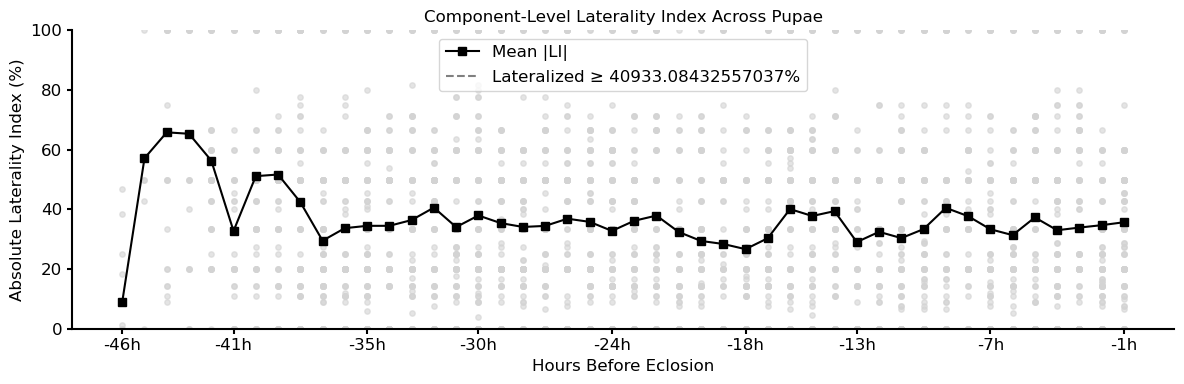

In [ ]:
from skimage.measure import label, regionprops

all_abs_lis = []  # list of (time_index, abs_LI_value) pairs

for pupa, nmfs in zip(pupae, all_nmfs):
    for i, (H_stack, _) in enumerate(nmfs):
        fg_idx = [ix for ix, h in enumerate(H_stack)
                  if utils.comp_sparsity(h) <= bg_sparsity_thrs[pupa]]
        for ix in fg_idx:
            comp = H_stack[ix]
            mask = utils.fractional_threshold(comp, fraction=0.3)
            lbl = label(mask > 0)
            props = [p for p in regionprops(lbl) if 30 <= p.area <= 2000]
            if len(props) >= 4:
                cents = [p.centroid for p in props]
                xs = [x for (y, x) in cents]
                mid = comp.shape[1] / 2
                nL = sum(xc < mid for xc in xs)
                nR = sum(xc >= mid for xc in xs)
                tot = nL + nR
                if tot >= 4:
                    abs_li = abs((nR - nL) / tot * 100)
                    all_abs_lis.append((i, abs_li))  # i is the time index
# Recompute mean LI per time point for overlay
all_lis = np.full((len(pupae), len(nmfs)), np.nan)
for pi, (pupa, nmfs) in enumerate(zip(pupae, all_nmfs)):
    for i, (H_stack, _) in enumerate(nmfs):
        fg_idx = [ix for ix, h in enumerate(H_stack)
                  if utils.comp_sparsity(h) <= bg_sparsity_thrs[pupa]]
        abs_li = []
        for ix in fg_idx:
            comp = H_stack[ix]
            mask = utils.fractional_threshold(comp, fraction=0.3)
            lbl = label(mask > 0)
            props = [p for p in regionprops(lbl) if 30 <= p.area <= 2000]
            if len(props) >= 4:
                cents = [p.centroid for p in props]
                xs = [x for (y, x) in cents]
                mid = comp.shape[1] / 2
                nL = sum(xc < mid for xc in xs)
                nR = sum(xc >= mid for xc in xs)
                tot = nL + nR
                if tot >= 4:
                    abs_li.append(abs((nR - nL) / tot * 100))
        all_lis[pi, i] = np.mean(abs_li) if abs_li else np.nan

threshold = 30
mean_li = np.nanmean(all_lis, axis=0)
std_li = np.nanstd(all_abs_lis, axis=0)
# Plot all component-level abs LI values as a light gray scatter
plt.figure(figsize=(12,4))
for i, abs_li in all_abs_lis:
    plt.scatter(x[i], abs_li, color='lightgray', alpha=0.6, s=15)

# Overlay mean line
plt.plot(x, mean_li, marker='s', linestyle='-', color='black', label='Mean |LI|')

# Optional threshold line
plt.axhline(threshold, color='gray', linestyle='--', label=f'Lateralized ≥ {threshold}%')

plt.xticks(tick_locs, tick_labels)
plt.xlabel("Hours Before Eclosion")
plt.ylabel("Absolute Laterality Index (%)")
plt.title("Component-Level Laterality Index Across Pupae")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from skimage.measure import label, regionprops

# 1) POOLED SERIES ACROSS PUPAE
# -----------------------------
n = len(all_nmfs[0])
t = np.arange(n)

# Blob‑count categories
cats = ['1 blob', '2–6 blobs', '7+ blobs']
all_counts = []
for pupa, nmfs in zip(pupae, all_nmfs):
    c1 = np.zeros(n); c2_6 = np.zeros(n); c7p = np.zeros(n)
    for i, (H_stack, _) in enumerate(nmfs):
        fg = [ix for ix,h in enumerate(H_stack) if utils.comp_sparsity(h) <= bg_sparsity_thrs[pupa]]
        blob_counts = []
        for ix in fg:
            comp = H_stack[ix]
            mask = utils.fractional_threshold(comp, fraction=0.3)
            lbl = label(mask > 0)
            props = [p for p in regionprops(lbl) if 30 <= p.area <= 2000]
            blob_counts.append(len(props))
        c1[i]   = np.sum([1 for x in blob_counts if x == 1])
        c2_6[i] = np.sum([1 for x in blob_counts if 2 <= x <= 6])
        c7p[i]  = np.sum([1 for x in blob_counts if x >= 7])
    all_counts.append(np.vstack([c1, c2_6, c7p]))
all_counts    = np.array(all_counts)              # shape (P,3,n)
mean_counts   = np.nanmean(all_counts, axis=0)    # shape (3,n)

# Mean |LI|
all_lis = np.full((len(pupae), n), np.nan)
for pi, (pupa, nmfs) in enumerate(zip(pupae, all_nmfs)):
    for i, (H_stack, _) in enumerate(nmfs):
        abs_li_list = []
        fg = [ix for ix,h in enumerate(H_stack) if utils.comp_sparsity(h) <= bg_sparsity_thrs[pupa]]
        for ix in fg:
            comp = H_stack[ix]
            mask = utils.fractional_threshold(comp, fraction=0.3)
            lbl = label(mask > 0)
            props = [p for p in regionprops(lbl) if 30 <= p.area <= 2000]
            if len(props) >= 4:
                xs = [c[1] for c in [p.centroid for p in props]]
                mid = comp.shape[1] / 2
                nL = sum(x < mid for x in xs)
                nR = sum(x >= mid for x in xs)
                tot = nL + nR
                if tot >= 4:
                    abs_li_list.append(abs((nR - nL) / tot * 100))
        all_lis[pi, i] = np.nan if not abs_li_list else np.mean(abs_li_list)
mean_li = np.nanmean(all_lis, axis=0)

# 2) TEST FUNCTION: ADF + KPSS + OLS trend
# ----------------------------------------
def adf_kpss_trend(name, y, t_index):
    # ADF with intercept+trend
    adf_stat, adf_p, *_ = adfuller(y, regression='c', autolag='AIC')
    # KPSS with trend term
    kpss_stat, kpss_p, *_ = kpss(y, regression='c', nlags='auto')
    # OLS for slope
    X = sm.add_constant(t_index)
    m = sm.OLS(y, X).fit()
    slope   = m.params[1]
    slope_p = m.pvalues[1]
    return {
        "metric":  name,
        "adf_p":   adf_p,
        "kpss_p":  kpss_p,
        "slope":   slope,
        "slope_p": slope_p
    }

# 3) RUN TESTS FOR BLOB CATEGORIES + GLOBAL |LI|
# -----------------------------------------------
results = []
for idx, cat in enumerate(cats):
    results.append(adf_kpss_trend(cat, mean_counts[idx], t))
results.append(adf_kpss_trend("Mean |LI|", mean_li, t))

# 4) PIECEWISE FOR MEAN |LI| @ knot = 10
# --------------------------------------
knot_li    = 10
y_li       = mean_li
post10     = np.maximum(0, t - knot_li)

# stationarity tests on full mean_li
adf_stat_li, adf_p_li, *_    = adfuller(y_li, regression='c', autolag='AIC')
kpss_stat_li, kpss_p_li, *_  = kpss(y_li, regression='c', nlags='auto')

# piecewise OLS: y_li ~ 1 + t + (t-10)+
X_li = sm.add_constant(np.column_stack([t, post10]))
mod_li = sm.OLS(y_li, X_li).fit()
s_pre10    = mod_li.params[1]
p_pre10    = mod_li.pvalues[1]
s_change10 = mod_li.params[2]
p_change10 = mod_li.pvalues[2]

results.append({
    "metric":        "Mean |LI| (piecewise)",
    "adf_p":         adf_p_li,
    "kpss_p":        kpss_p_li,
    "slope_0_10":    s_pre10,
    "p_0_10":        p_pre10,
    "slope_10_end":  s_pre10 + s_change10,
    "p_change":      p_change10
})

# 5) DISPLAY
# ------------
df_res = pd.DataFrame(results)
print(df_res.to_string(index=False))


               metric    adf_p   kpss_p     slope      slope_p  slope_0_10   p_0_10  slope_10_end  p_change
               1 blob 0.292213 0.010000  0.213987 3.022659e-10         NaN      NaN           NaN       NaN
            2–6 blobs 0.046384 0.097704  0.192673 6.832302e-04         NaN      NaN           NaN       NaN
             7+ blobs 0.019402 0.024474  0.093543 3.050507e-06         NaN      NaN           NaN       NaN
            Mean |LI| 0.000078 0.056764 -0.277265 9.518690e-03         NaN      NaN           NaN       NaN
Mean |LI| (piecewise) 0.000078 0.056764       NaN          NaN   -1.399674 0.022348     -0.106151  0.060491


C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\2433582806.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression='c', nlags='auto')


C:\Users\lpedu\AppData\Local\Temp\ipykernel_18152\3523136455.py:49: RuntimeWarning: invalid value encountered in divide
  "pct":   (c1/ (c1+c2+c7)*100, c2/(c1+c2+c7)*100, c7/(c1+c2+c7)*100),


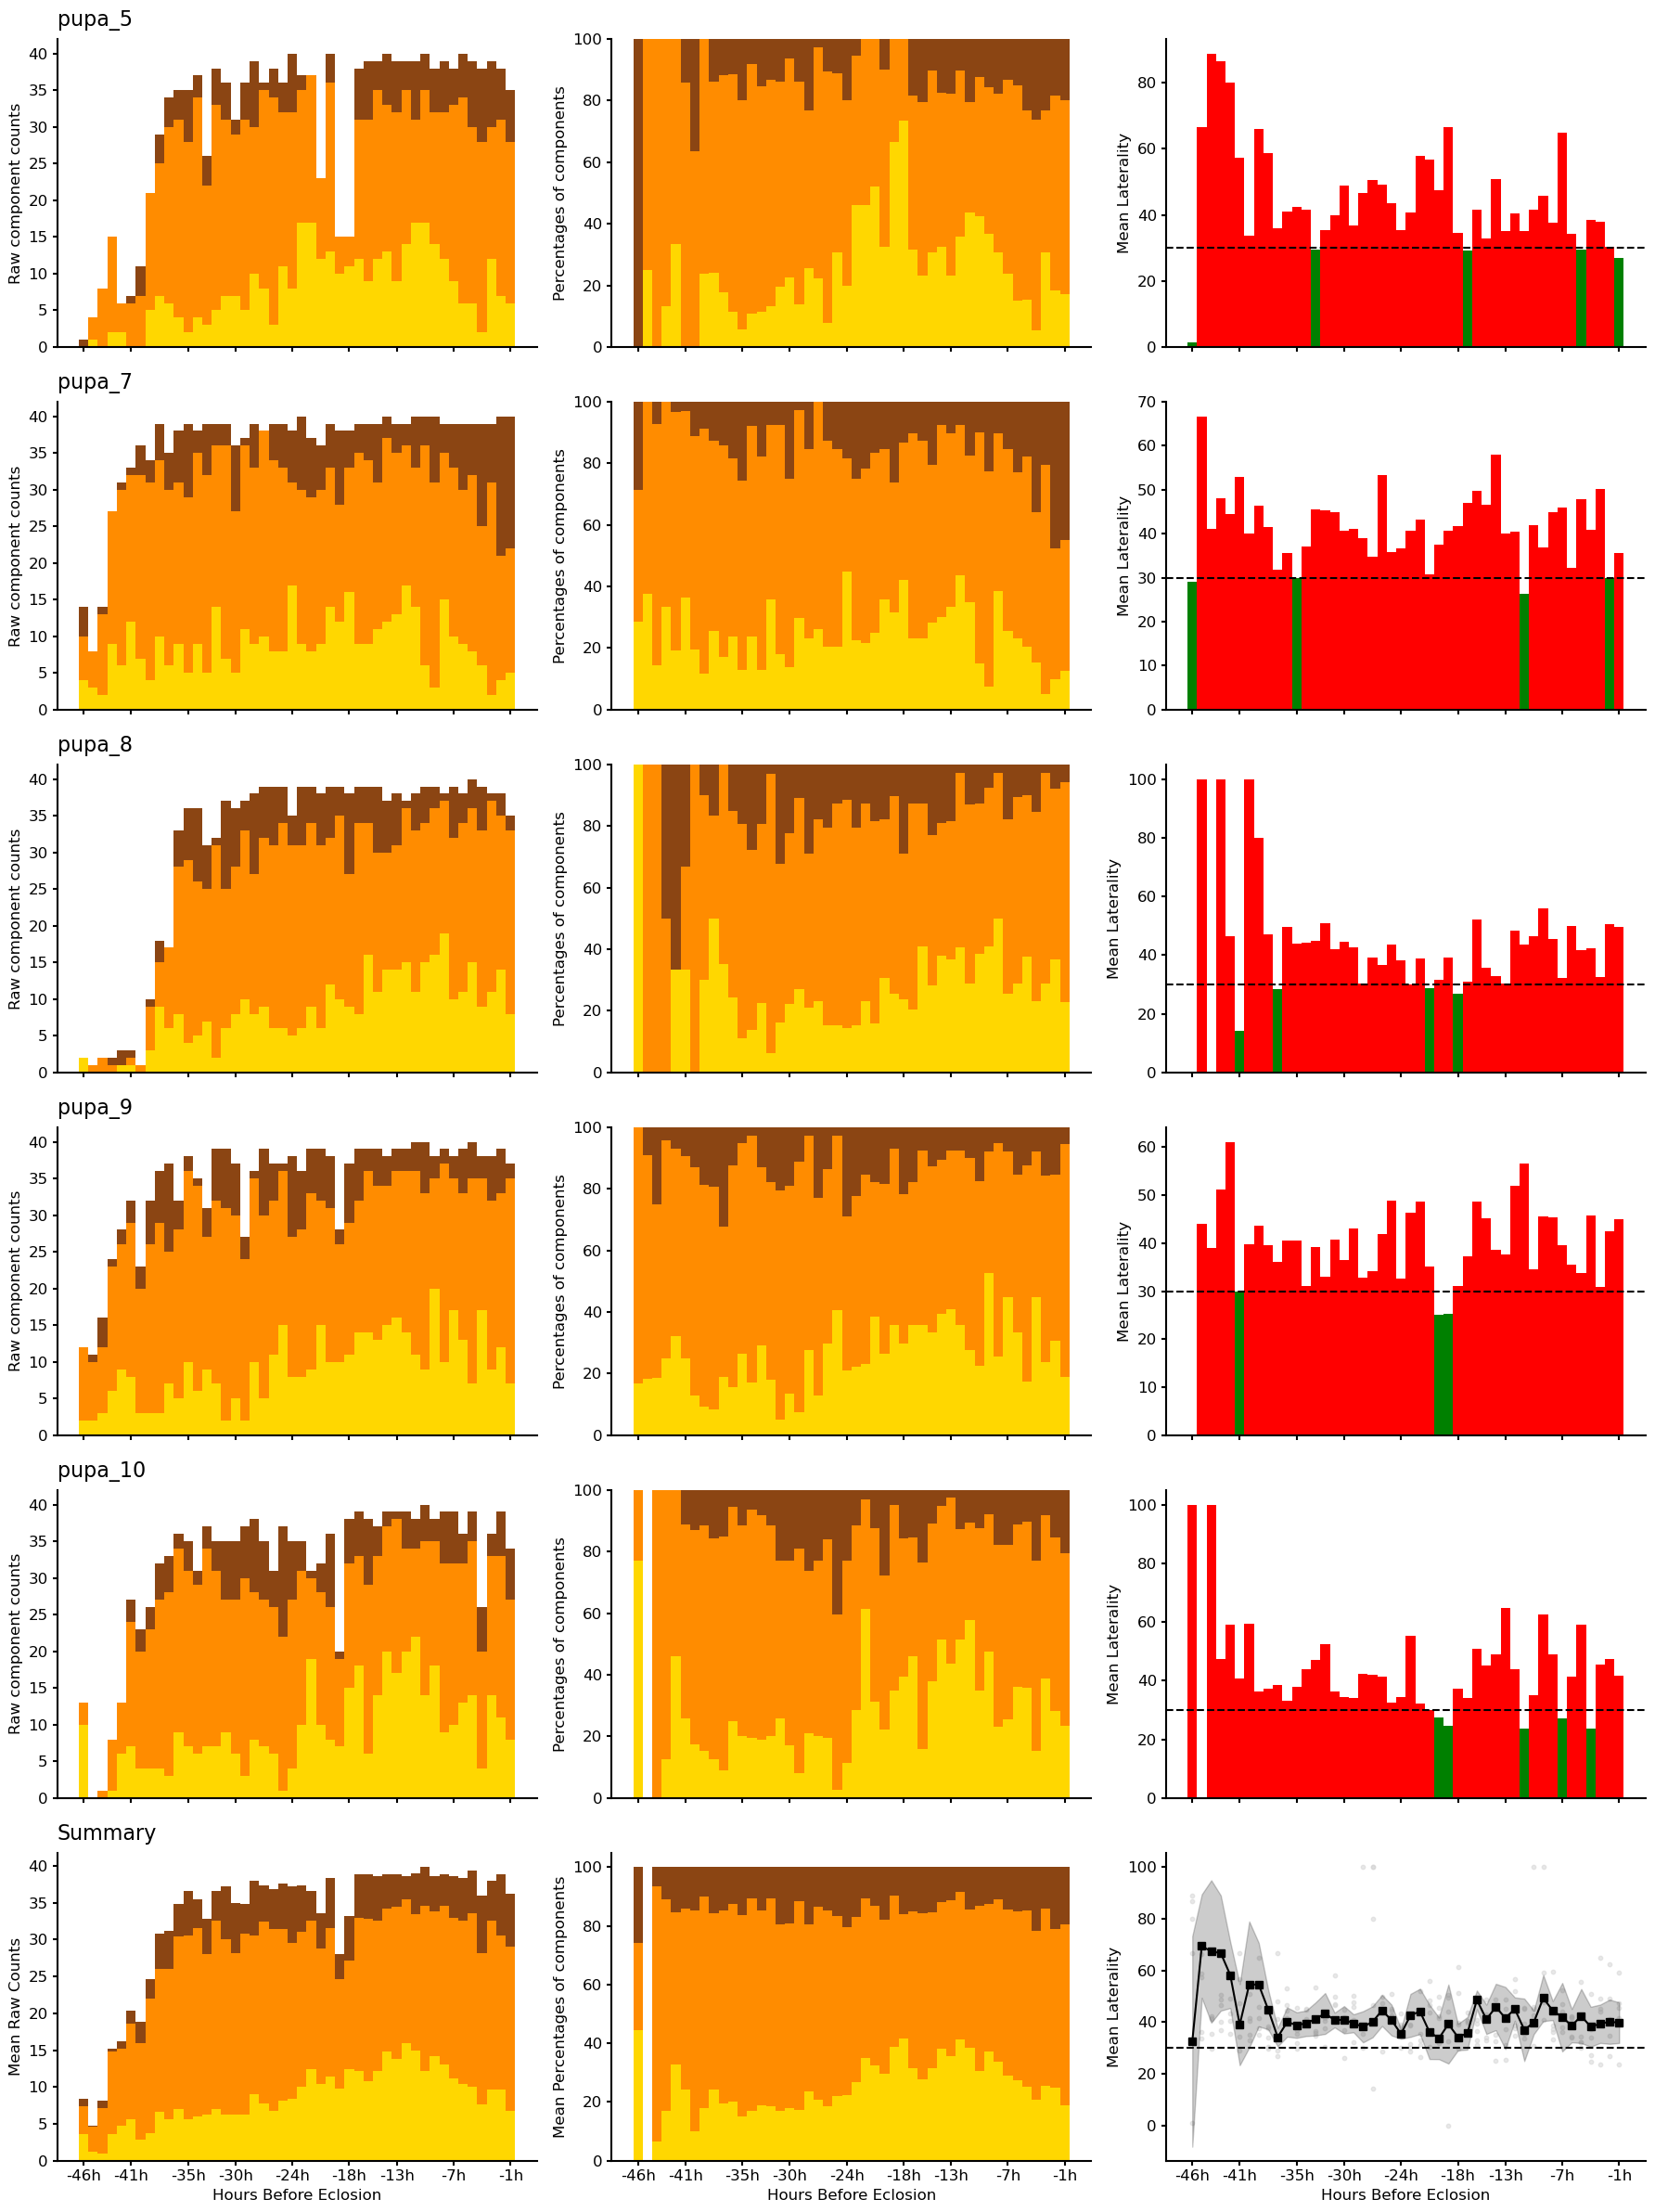

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


n_videos = len(all_nmfs[0])
x = np.arange(n_videos)
cats = ['1 blob','2–6 blobs','7+ blobs']
cat_colors = ["gold","darkorange","saddlebrown"]
bar_width = 1.0

# Precompute per-pupa arrays
per_pupa = {}
for pupa, nmfs in zip(pupae, all_nmfs):
    # storage
    c1 = np.zeros(n_videos,int)
    c2 = np.zeros(n_videos,int)
    c7 = np.zeros(n_videos,int)
    li = np.full(n_videos, np.nan)
    
    for t,(H,W) in enumerate(nmfs):
        sparsities = [utils.comp_sparsity(h) for h in H]
        fg = [i for i,s in enumerate(sparsities) if s<=bg_sparsity_thrs[pupa]]
        blob_counts=[]; L=[]
        for i in fg:
            comp = H[i]
            mask = utils.fractional_threshold(comp,0.3)
            lbl = label(mask>0)
            props=[p for p in regionprops(lbl) if 30<=p.area<=2000]
            blob_counts.append(len(props))
            if len(props)>=2:
                cents=[p.centroid for p in props]
                xs=[x for (y,x) in cents]
                mid=comp.shape[1]/2
                nL=sum(xc<mid for xc in xs)
                nR=sum(xc>=mid for xc in xs)
                tot=nL+nR
                if tot>=3:
                    L.append(abs((nR-nL)/tot*100))
        c1[t]=sum(n==1 for n in blob_counts)
        c2[t]=sum(2<=n<=6 for n in blob_counts)
        c7[t]=sum(n>=7 for n in blob_counts)
        li[t]=np.mean(L) if L else np.nan
    
    per_pupa[pupa]={
        "raw":   (c1,c2,c7),
        "pct":   (c1/ (c1+c2+c7)*100, c2/(c1+c2+c7)*100, c7/(c1+c2+c7)*100),
        "li":    li
    }

# Summary arrays
all_raw = np.stack([per_pupa[p]["raw"] for p in pupae])  # shape (5,3,N)
mean_raw = all_raw.mean(axis=0)                          # shape (3,N)
all_pct = np.stack([per_pupa[p]["pct"] for p in pupae])
mean_pct = all_pct.mean(axis=0)
all_li = np.stack([per_pupa[p]["li"] for p in pupae])
mean_li = np.nanmean(all_li, axis=0)

threshold = 30
# Make 6×3 grid
fig, axs = plt.subplots(6,3,figsize=(18,24), sharex=True)
for i,pupa in enumerate(pupae):
    c1,c2,c7 = per_pupa[pupa]["raw"]
    ax=axs[i,0]
    ax.bar(x, c1, color=cat_colors[0], width=bar_width)
    ax.bar(x, c2, bottom=c1, color=cat_colors[1], width=bar_width)
    ax.bar(x, c7, bottom=c1+c2, color=cat_colors[2], width=bar_width)
    ax.set_ylabel("Raw component counts"); ax.set_title(pupa, loc='left', fontsize=16, pad=10)
    ax.grid(False)
    
    p1,p2,p7 = per_pupa[pupa]["pct"]
    ax=axs[i,1]
    ax.bar(x, p1, color=cat_colors[0], width=bar_width)
    ax.bar(x, p2, bottom=p1, color=cat_colors[1], width=bar_width)
    ax.bar(x, p7, bottom=p1+p2, color=cat_colors[2], width=bar_width)
    ax.set_ylabel("Percentages of components")
    ax.grid(False)
    
    li = per_pupa[pupa]["li"]
    colors = ['red' if v>=threshold else 'green' for v in li]
    ax=axs[i,2]
    ax.bar(x, li, color=colors, width=bar_width)
    ax.axhline(threshold, color='black', linestyle='--')
    ax.set_ylabel("Mean Laterality")
    ax.grid(False)

# Summary row i=5
# Raw
ax=axs[5,0]
ax.bar(x, mean_raw[0], color=cat_colors[0], width=bar_width)
ax.bar(x, mean_raw[1], bottom=mean_raw[0], color=cat_colors[1], width=bar_width)
ax.bar(x, mean_raw[2], bottom=mean_raw[0]+mean_raw[1], color=cat_colors[2], width=bar_width)
ax.set_ylabel("Mean Raw Counts"); ax.set_title("Summary",loc='left',fontsize=16, pad=10)
ax.grid(False)

# Percent
ax=axs[5,1]
ax.bar(x, mean_pct[0], color=cat_colors[0], width=bar_width)
ax.bar(x, mean_pct[1], bottom=mean_pct[0], color=cat_colors[1], width=bar_width)
ax.bar(x, mean_pct[2], bottom=mean_pct[0]+mean_pct[1], color=cat_colors[2], width=bar_width)
ax.set_ylabel("Mean Percentages of components")
ax.grid(False)

# Laterality
ax=axs[5,2]
ax.scatter(np.repeat(x,len(pupae)), all_li.ravel(), color='lightgray', s=10, alpha=0.5)
ax.plot(x, mean_li, marker='s', color='black')
ax.axhline(threshold, color='black', linestyle='--')
ax.set_ylabel("Mean Laterality")
ax.grid(False)
std_li  = np.nanstd(all_li, axis=0)     # shape (n_videos,)
# Shade mean ±1 SD
ax.fill_between(x,
                mean_li - std_li,
                mean_li + std_li,
                color='black',
                alpha=0.2,
                label='±1 SD')

# x-axis on bottom row
for j in range(3):
    axs[5,j].set_xticks(tick_locs)
    axs[5,j].set_xticklabels(tick_labels)
    axs[5,j].set_xlabel("Hours Before Eclosion")

plt.tight_layout()
plt.show()


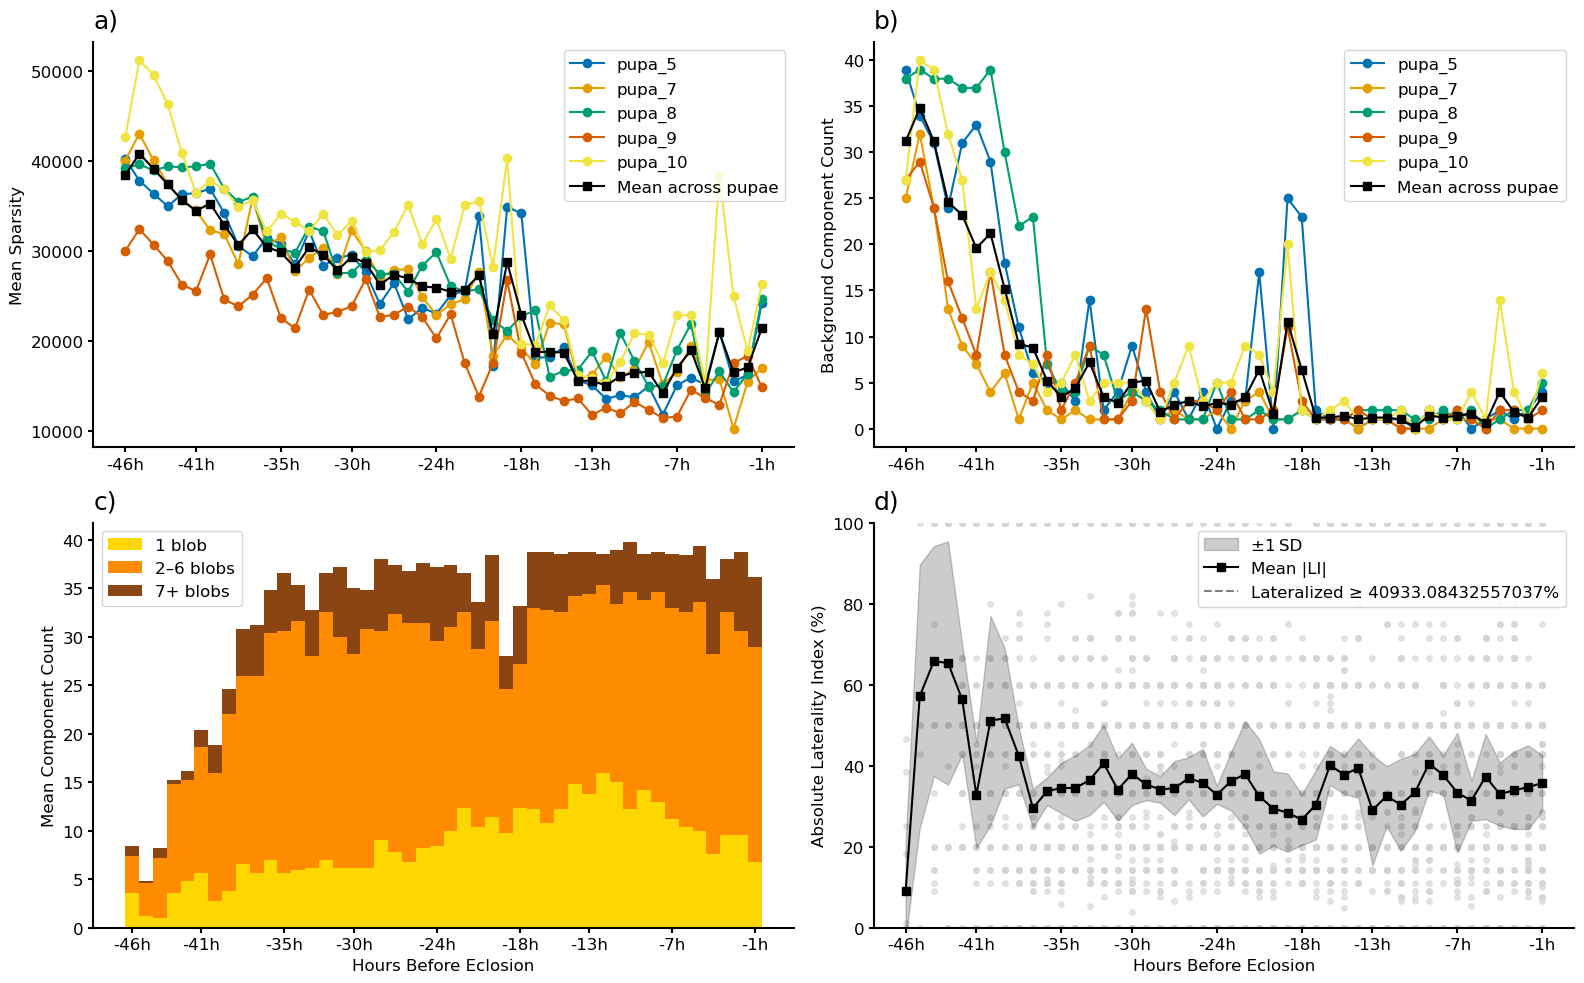

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Flatten to easily index 0–3
idx = np.arange(46)
# --- Plot 1: Mean Sparsity ---
ax = axes[0]
name = "SP"
for pupa in pupae:
    ax.plot(idx, metrics[pupa][name], marker='o', label=pupa, color=pupa_colors[pupa])
all_data = np.vstack([metrics[p][name] for p in pupae])
mean_curve = np.nanmean(all_data, axis=0)
ax.plot(idx, mean_curve, marker='s', color='black', linestyle='-', label='Mean across pupae', linewidth=1.5)
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.set_title("a)",loc="left", pad=10,fontsize=18)

ax.set_ylabel("Mean Sparsity")
ax.legend()

# --- Plot 2: Background Component Count ---
ax = axes[1]
name = "BG_COUNT"
for pupa in pupae:
    ax.plot(idx, metrics[pupa][name], marker='o', label=pupa, color=pupa_colors[pupa])
all_data = np.vstack([metrics[p][name] for p in pupae])
mean_curve = np.nanmean(all_data, axis=0)
ax.plot(idx, mean_curve, marker='s', color='black', linestyle='-', label='Mean across pupae', linewidth=1.5)
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.set_title("b)",loc="left", pad=10,fontsize=18)
ax.set_ylabel("Background Component Count")
ax.legend()

# --- Plot 3: Component Category Counts ---
ax = axes[2]
bottom = np.zeros_like(mean_counts[0])
for i in range(3):
    ax.bar(x, mean_counts[i], bottom=bottom, label=cats[i], color=cat_colors[i], width=bar_width)
    bottom += mean_counts[i]
ax.set_title("c)",loc="left", pad=10,fontsize=18)
ax.set_xlabel("Hours Before Eclosion")
ax.set_ylabel("Mean Component Count")
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.legend()

# --- Plot 4: Component‑Level Laterality Index with ±1 SD shading ---
from collections import defaultdict

# all_abs_lis is a list of (time_idx, abs_li) from before
per_time_vals = defaultdict(list)
for time_idx, abs_li in all_abs_lis:
    per_time_vals[time_idx].append(abs_li)

# build arrays in order of x=0…N-1
std_all_li = np.array([
    np.std(per_time_vals[t]) if per_time_vals[t] else np.nan
    for t in x
], dtype=float)
ax = axes[3]
# Scatter all individual component‑level LI values
for i, abs_li in all_abs_lis:
    ax.scatter(x[i], abs_li,
               color='lightgray',
               alpha=0.6,
               s=15)
# Compute mean and std across pupae
mean_li = np.nanmean(all_lis, axis=0)    # shape (n_videos,)
std_li  = np.nanstd(all_lis, axis=0)     # shape (n_videos,)
# Shade mean ±1 SD
ax.fill_between(x,
                mean_li - std_li,
                mean_li + std_li,
                color='black',
                alpha=0.2,
                label='±1 SD')
# Plot mean line
ax.plot(x, mean_li,
        marker='s',
        linestyle='-',
        color='black',
        label='Mean |LI|',
        linewidth=1.5)
# Threshold line
ax.axhline(threshold,
           color='gray',
           linestyle='--',
           label=f'Lateralized ≥ {threshold}%')
# Formatting
ax.set_title("d)", loc='left', pad=10,fontsize=18)
ax.set_xlabel("Hours Before Eclosion")
ax.set_ylabel("Absolute Laterality Index (%)")
ax.set_ylim(0, 100)
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
# Single legend entry for the shading and lines
ax.legend()
plt.tight_layout()
plt.show()

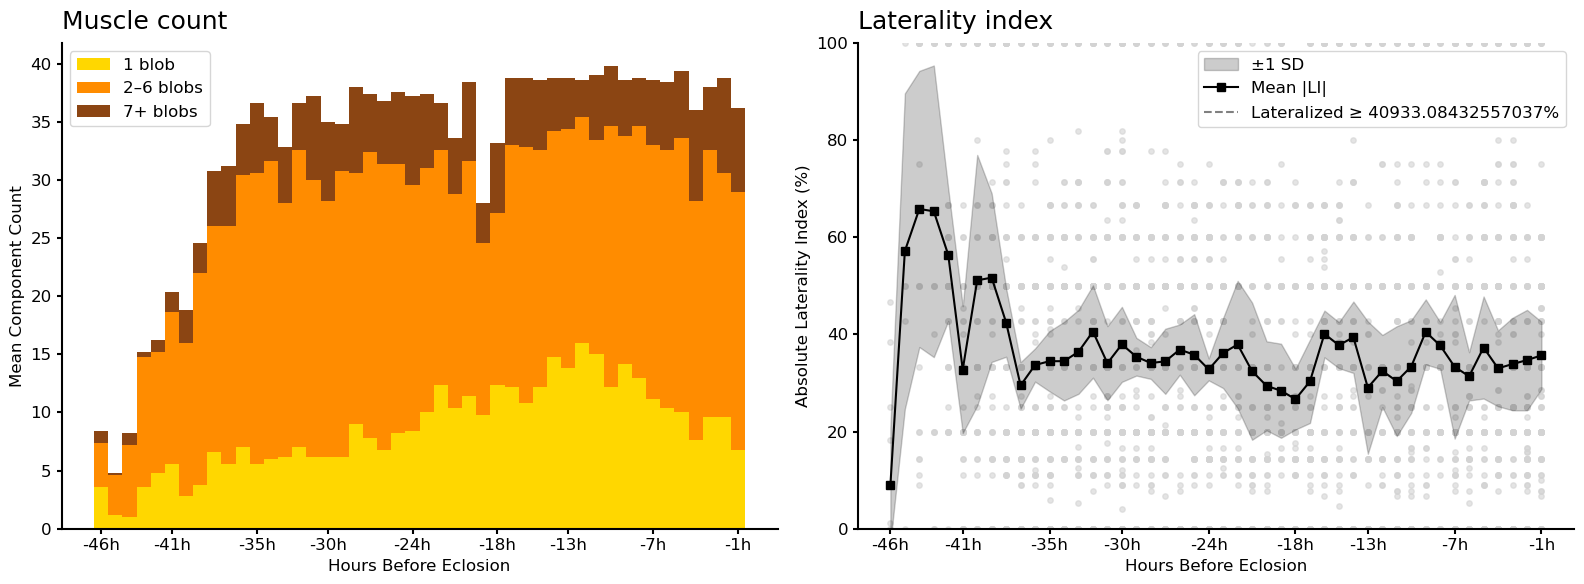

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

# ——— Plot 3 (Component Category Counts) on axes[0] ———
ax = axes[0]
bottom = np.zeros_like(mean_counts[0]) 

for i in range(len(cats)):
    ax.bar(
        x,
        mean_counts[i],
        bottom=bottom,
        label=cats[i],
        color=cat_colors[i],
        width=bar_width
    )
    bottom += mean_counts[i]

ax.set_title("Muscle count", loc="left", pad=10, fontsize=18)
ax.set_xlabel("Hours Before Eclosion")
ax.set_ylabel("Mean Component Count")
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.legend()

# ——— Plot 4 (Component-Level Laterality Index with ±1 SD shading) on axes[1] ———
ax = axes[1]

# Scatter all individual |LI| points in light gray
for time_idx, abs_li in all_abs_lis:
    ax.scatter(
        x[time_idx],
        abs_li,
        color="lightgray",
        alpha=0.6,
        s=15
    )

# Compute mean and std across rows of all_lis (shape: n_pupae × len(x))
mean_li = np.nanmean(all_lis, axis=0)    # shape: (len(x),)
std_li  = np.nanstd(all_lis, axis=0)     # shape: (len(x),)

# Shade mean ±1 SD
ax.fill_between(
    x,
    mean_li - std_li,
    mean_li + std_li,
    color="black",
    alpha=0.2,
    label="±1 SD"
)

# Plot mean |LI| as a solid black line with square markers
ax.plot(
    x,
    mean_li,
    marker="s",
    linestyle="-",
    color="black",
    label="Mean |LI|",
    linewidth=1.5
)

# Add a horizontal threshold line
ax.axhline(
    threshold,
    color="gray",
    linestyle="--",
    label=f"Lateralized ≥ {threshold}%"
)

ax.set_title("Laterality index", loc="left", pad=10, fontsize=18)
ax.set_xlabel("Hours Before Eclosion")
ax.set_ylabel("Absolute Laterality Index (%)")
ax.set_ylim(0, 100)
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)
ax.legend()

plt.tight_layout()
plt.show()
